In [1]:
from google.cloud import storage
import pandas as pd
import io
import os

bucket_name = "imdb_data_raw"
folder_path = "parquet_files/"

client = storage.Client()
bucket = client.bucket(bucket_name)

blobs = list(bucket.list_blobs(prefix=folder_path))
parquet_blobs = [blob for blob in blobs if blob.name.endswith(".parquet")]

print(f"Found {len(parquet_blobs)} Parquet files.")

# File to track completed files
progress_file = "processed_files.txt"

# Load processed files if exists
if os.path.exists(progress_file):
    with open(progress_file, "r") as f:
        processed = set(line.strip() for line in f.readlines())
else:
    processed = set()

for blob in parquet_blobs:
    file_key = blob.name.split("/")[-1].replace(".parquet", "")

    if file_key in processed:
        print(f"Skipping {file_key} (already processed).")
        continue

    print(f"Processing {file_key} ...")

    try:
        parquet_bytes = blob.download_as_bytes()
        df = pd.read_parquet(io.BytesIO(parquet_bytes))

        globals()[f"df_{file_key}"] = df
        print(f"Loaded df_{file_key} with shape {df.shape}")

        # Mark as processed
        with open(progress_file, "a") as f:
            f.write(file_key + "\n")

        # Optional: del df

    except Exception as e:
        print(f"Error loading {file_key}: {e}")

Found 7 Parquet files.
Processing name_basics ...
Loaded df_name_basics with shape (14461634, 6)
Processing title_akas ...
Loaded df_title_akas with shape (52165025, 8)
Processing title_basic ...
Loaded df_title_basic with shape (11702150, 9)
Processing title_crew ...
Loaded df_title_crew with shape (11702150, 3)
Processing title_episode ...
Loaded df_title_episode with shape (9005206, 4)
Processing title_principals ...
Loaded df_title_principals with shape (92953607, 6)
Processing title_ratings ...
Loaded df_title_ratings with shape (1575801, 3)


In [8]:
import pandas as pd
import os
from pathlib import Path

def chunk_dataframe(df, chunk_size, output_dir, base_filename):
    """
    Divide a DataFrame into chunks and save them as separate files
    
    Parameters:
    df: pandas DataFrame to chunk
    chunk_size: number of rows per chunk
    output_dir: directory to save chunks
    base_filename: base name for chunk files
    """
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    total_rows = len(df)
    num_chunks = (total_rows + chunk_size - 1) // chunk_size  # Ceiling division
    
    print(f"Dividing {base_filename} ({total_rows:,} rows) into {num_chunks} chunks of ~{chunk_size:,} rows each")
    
    chunk_info = []
    
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, total_rows)
        
        chunk_df = df.iloc[start_idx:end_idx].copy()
        chunk_filename = f"{base_filename}_chunk_{i+1:03d}.parquet"
        chunk_path = os.path.join(output_dir, chunk_filename)
        
        # Save chunk as parquet for efficiency
        chunk_df.to_parquet(chunk_path, index=False)
        
        chunk_info.append({
            'chunk_number': i+1,
            'filename': chunk_filename,
            'rows': len(chunk_df),
            'start_row': start_idx,
            'end_row': end_idx-1,
            'file_path': chunk_path
        })
        
        print(f"  Saved chunk {i+1}/{num_chunks}: {chunk_filename} ({len(chunk_df):,} rows)")
    
    return chunk_info

# Configuration - adjust chunk sizes based on your memory constraints
CHUNK_CONFIGS = {
    'name_basics': {
        'chunk_size': 50000,  # 500K rows per chunk
        'df_name': 'df_name_basics'
    },
    'title_akas': {
        'chunk_size': 50000,  # 1M rows per chunk  
        'df_name': 'df_title_akas'
    },
    'title_basic': {
        'chunk_size': 50000,   # 500K rows per chunk
        'df_name': 'df_title_basic'
    },
    'title_crew': {
        'chunk_size': 50000,   # 500K rows per chunk
        'df_name': 'df_title_crew'
    },
    'title_episode': {
        'chunk_size': 50000,   # 500K rows per chunk
        'df_name': 'df_title_episode'
    },
    'title_principals': {
        'chunk_size': 500000,  # 2M rows per chunk (largest dataset)
        'df_name': 'df_title_principals'
    },
    'title_ratings': {
        'chunk_size': 50000,   # 200K rows per chunk (smallest dataset)
        'df_name': 'df_title_ratings'
    }
}

# Main chunking process
def chunk_all_datasets():
    """Process all loaded datasets and create chunks"""
    
    # Dictionary to store all chunk information
    all_chunk_info = {}
    
    for dataset_name, config in CHUNK_CONFIGS.items():
        print(f"\n{'='*60}")
        print(f"Processing {dataset_name.upper()}")
        print(f"{'='*60}")
        
        # Get the dataframe from globals (assuming they're loaded)
        df_name = config['df_name']
        if df_name in globals():
            df = globals()[df_name]
            
            # Create chunks
            output_dir = f"chunks/{dataset_name}"
            chunk_info = chunk_dataframe(
                df=df,
                chunk_size=config['chunk_size'],
                output_dir=output_dir,
                base_filename=dataset_name
            )
            
            all_chunk_info[dataset_name] = {
                'original_rows': len(df),
                'original_columns': len(df.columns),
                'chunk_size': config['chunk_size'],
                'num_chunks': len(chunk_info),
                'chunks': chunk_info
            }
            
            # Clear the original dataframe from memory to save space
            del globals()[df_name]
            print(f"Cleared {df_name} from memory")
            
        else:
            print(f"Warning: {df_name} not found in memory")
    
    return all_chunk_info

# Helper function to load a specific chunk for analysis
def load_chunk(dataset_name, chunk_number):
    """
    Load a specific chunk for analysis
    
    Parameters:
    dataset_name: name of the dataset (e.g., 'title_basics')
    chunk_number: chunk number to load (1-indexed)
    
    Returns:
    pandas DataFrame
    """
    chunk_path = f"chunks/{dataset_name}/{dataset_name}_chunk_{chunk_number:03d}.parquet"
    
    if os.path.exists(chunk_path):
        df = pd.read_parquet(chunk_path)
        print(f"Loaded {dataset_name} chunk {chunk_number}: {len(df):,} rows, {len(df.columns)} columns")
        return df
    else:
        print(f"Chunk file not found: {chunk_path}")
        return None

# Helper function to get chunk summary
def get_chunk_summary(all_chunk_info):
    """Print a summary of all chunks created"""
    print("\n" + "="*80)
    print("CHUNK SUMMARY")
    print("="*80)
    
    total_original_rows = 0
    total_chunks = 0
    
    for dataset_name, info in all_chunk_info.items():
        print(f"\n{dataset_name.upper()}:")
        print(f"  Original size: {info['original_rows']:,} rows × {info['original_columns']} columns")
        print(f"  Chunk size: {info['chunk_size']:,} rows")
        print(f"  Number of chunks: {info['num_chunks']}")
        print(f"  Storage location: chunks/{dataset_name}/")
        
        total_original_rows += info['original_rows']
        total_chunks += info['num_chunks']
    
    print(f"\nTOTAL SUMMARY:")
    print(f"  Original total rows: {total_original_rows:,}")
    print(f"  Total chunks created: {total_chunks}")
    print(f"  Average chunk size: {total_original_rows // total_chunks:,} rows")

# Example usage functions
def analyze_sample_data():
    """Example: Load and analyze a small sample from each dataset"""
    datasets = ['name_basics', 'title_basic', 'title_ratings']
    
    for dataset in datasets:
        print(f"\n--- Sample from {dataset} ---")
        chunk = load_chunk(dataset, 1)  # Load first chunk
        if chunk is not None:
            print(f"Columns: {list(chunk.columns)}")
            print(f"Data types:\n{chunk.dtypes}")
            print(f"First 3 rows:\n{chunk.head(3)}")

# Run the chunking process
if __name__ == "__main__":
    # Execute the chunking
    chunk_info = chunk_all_datasets()
    
    # Show summary
    get_chunk_summary(chunk_info)
    
    # Example analysis
    print(f"\n{'='*60}")
    print("EXAMPLE: Loading chunks for analysis")
    print(f"{'='*60}")
    
    # Load first chunk of title_ratings for quick analysis
    ratings_chunk = load_chunk('title_ratings', 1)
    if ratings_chunk is not None:
        print(f"\nBasic stats for title_ratings chunk 1:")
        print(ratings_chunk.describe())


Processing NAME_BASICS

Processing TITLE_AKAS

Processing TITLE_BASIC
Dividing title_basic (11,702,150 rows) into 235 chunks of ~50,000 rows each
  Saved chunk 1/235: title_basic_chunk_001.parquet (50,000 rows)
  Saved chunk 2/235: title_basic_chunk_002.parquet (50,000 rows)
  Saved chunk 3/235: title_basic_chunk_003.parquet (50,000 rows)
  Saved chunk 4/235: title_basic_chunk_004.parquet (50,000 rows)
  Saved chunk 5/235: title_basic_chunk_005.parquet (50,000 rows)
  Saved chunk 6/235: title_basic_chunk_006.parquet (50,000 rows)
  Saved chunk 7/235: title_basic_chunk_007.parquet (50,000 rows)
  Saved chunk 8/235: title_basic_chunk_008.parquet (50,000 rows)
  Saved chunk 9/235: title_basic_chunk_009.parquet (50,000 rows)
  Saved chunk 10/235: title_basic_chunk_010.parquet (50,000 rows)
  Saved chunk 11/235: title_basic_chunk_011.parquet (50,000 rows)
  Saved chunk 12/235: title_basic_chunk_012.parquet (50,000 rows)
  Saved chunk 13/235: title_basic_chunk_013.parquet (50,000 rows)
  Sa

Creating Adult Content vs Average Rating Visualization
Loading data chunks to find both content types...
Loaded chunk 1: 32,147 rows
Current unique isAdult values: ['0']
Loaded chunk 2: 27,119 rows
Current unique isAdult values: ['0' '1']
Found sufficient data diversity after 2 chunks

Final merged dataset size: 59,266 rows
Columns: ['tconst', 'isAdult', 'averageRating']
isAdult unique values: [0 1]
averageRating range: 1.0 - 9.8


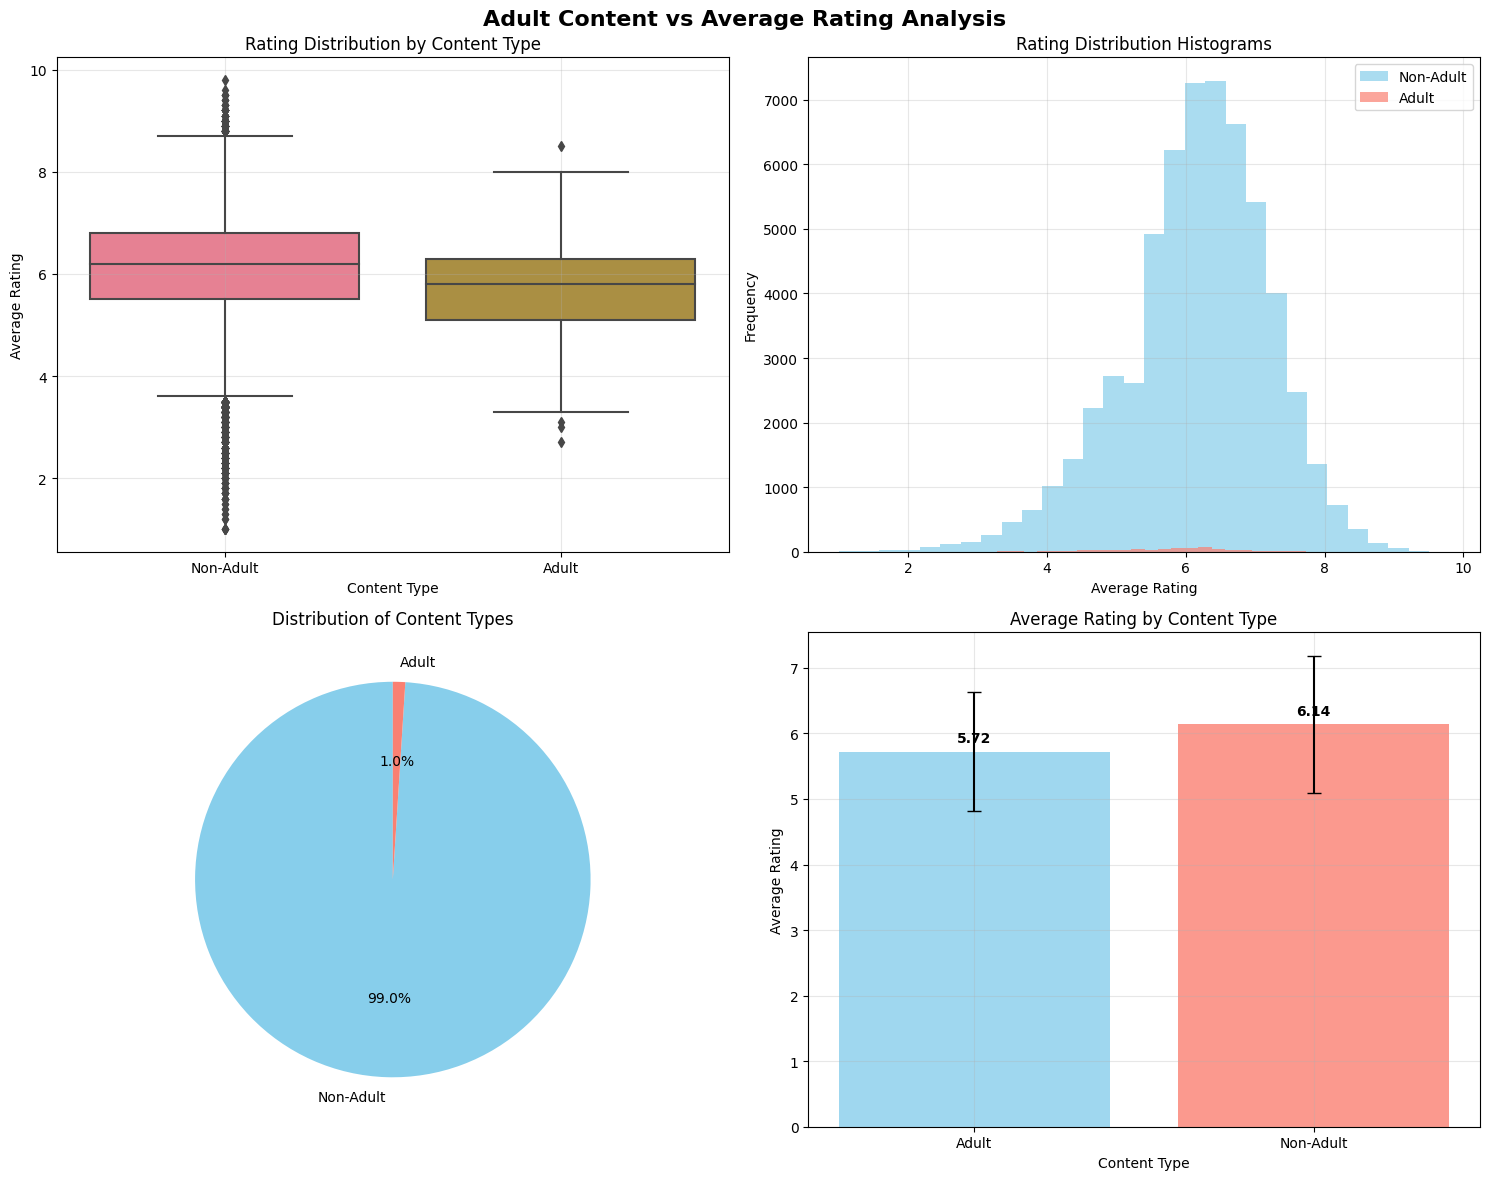


SUMMARY STATISTICS
             count  mean  median   std  min  max
adult_label                                     
Adult          598  5.72     5.8  0.91  2.7  8.5
Non-Adult    58668  6.14     6.2  1.04  1.0  9.8

Statistical Test (T-test):
T-statistic: 9.7144
P-value: 0.0000
Significant difference: Yes (α = 0.05)

Analysis completed with 59,266 titles


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

def create_adult_rating_visualization():
    """
    Create visualization comparing isAdult content with average ratings
    """
    
    # Load multiple chunks to find both adult and non-adult content
    print("Loading data chunks to find both content types...")
    
    merged_data = None
    chunks_loaded = 0
    max_chunks_to_try = 5
    
    for chunk_num in range(1, max_chunks_to_try + 1):
        try:
            # Load chunks
            basics_chunk = pd.read_parquet(f"chunks/title_basic/title_basic_chunk_{chunk_num:03d}.parquet")
            ratings_chunk = pd.read_parquet(f"chunks/title_ratings/title_ratings_chunk_{chunk_num:03d}.parquet")
            
            # Join the datasets on tconst (title identifier)
            chunk_merged = pd.merge(
                basics_chunk[['tconst', 'isAdult']], 
                ratings_chunk[['tconst', 'averageRating']], 
                on='tconst', 
                how='inner'
            )
            
            if merged_data is None:
                merged_data = chunk_merged
            else:
                merged_data = pd.concat([merged_data, chunk_merged], ignore_index=True)
            
            chunks_loaded += 1
            print(f"Loaded chunk {chunk_num}: {len(chunk_merged):,} rows")
            
            # Check if we have both adult and non-adult content
            unique_values = merged_data['isAdult'].unique()
            print(f"Current unique isAdult values: {unique_values}")
            
            # Stop if we have both types or enough data
            if len(unique_values) > 1 or len(merged_data) > 100000:
                print(f"Found sufficient data diversity after {chunks_loaded} chunks")
                break
                
        except FileNotFoundError:
            print(f"Chunk {chunk_num} not found")
            break
        except Exception as e:
            print(f"Error loading chunk {chunk_num}: {e}")
            continue
    
    if merged_data is None or len(merged_data) == 0:
        print("No data loaded successfully")
        return None
    
    print(f"\nFinal merged dataset size: {len(merged_data):,} rows")
    print(f"Columns: {list(merged_data.columns)}")
    
    # Convert isAdult to integer if it's string
    if merged_data['isAdult'].dtype == 'object':
        merged_data['isAdult'] = merged_data['isAdult'].astype(int)
    
    # Check data types and unique values
    unique_adult_values = merged_data['isAdult'].unique()
    print(f"isAdult unique values: {unique_adult_values}")
    print(f"averageRating range: {merged_data['averageRating'].min():.1f} - {merged_data['averageRating'].max():.1f}")
    
    # Check if we have both adult and non-adult content
    has_both_types = len(unique_adult_values) > 1
    
    if not has_both_types:
        print(f"\nWarning: Only found content type {unique_adult_values[0]} in the loaded data")
        print("Creating simplified visualization for single content type...")
        return create_single_type_visualization(merged_data)
    
    # Create the visualization for both types
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Adult Content vs Average Rating Analysis', fontsize=16, fontweight='bold')
    
    # 1. Box plot comparing ratings by adult content
    ax1 = axes[0, 0]
    adult_labels = {0: 'Non-Adult', 1: 'Adult'}
    merged_data['adult_label'] = merged_data['isAdult'].map(adult_labels)
    
    sns.boxplot(data=merged_data, x='adult_label', y='averageRating', ax=ax1)
    ax1.set_title('Rating Distribution by Content Type')
    ax1.set_xlabel('Content Type')
    ax1.set_ylabel('Average Rating')
    ax1.grid(True, alpha=0.3)
    
    # 2. Histogram of ratings split by adult content
    ax2 = axes[0, 1]
    for adult_val in unique_adult_values:
        label = adult_labels.get(adult_val, f'Type {adult_val}')
        color = 'skyblue' if adult_val == 0 else 'salmon'
        merged_data[merged_data['isAdult'] == adult_val]['averageRating'].hist(
            alpha=0.7, bins=30, label=label, ax=ax2, color=color
        )
    ax2.set_title('Rating Distribution Histograms')
    ax2.set_xlabel('Average Rating')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Count of titles by content type
    ax3 = axes[1, 0]
    content_counts = merged_data['adult_label'].value_counts()
    colors = ['skyblue', 'salmon'][:len(content_counts)]
    wedges, texts, autotexts = ax3.pie(
        content_counts.values, 
        labels=content_counts.index, 
        autopct='%1.1f%%',
        colors=colors,
        startangle=90
    )
    ax3.set_title('Distribution of Content Types')
    
    # 4. Average rating by content type (bar chart)
    ax4 = axes[1, 1]
    avg_ratings = merged_data.groupby('adult_label')['averageRating'].agg(['mean', 'std']).reset_index()
    
    bars = ax4.bar(avg_ratings['adult_label'], avg_ratings['mean'], 
                   yerr=avg_ratings['std'], capsize=5, 
                   color=colors[:len(avg_ratings)], alpha=0.8)
    ax4.set_title('Average Rating by Content Type')
    ax4.set_xlabel('Content Type')
    ax4.set_ylabel('Average Rating')
    ax4.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, mean_val in zip(bars, avg_ratings['mean']):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{mean_val:.2f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    
    summary_stats = merged_data.groupby('adult_label')['averageRating'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)
    
    print(summary_stats)
    
    # Statistical comparison (only if we have both types)
    if len(unique_adult_values) > 1:
        from scipy import stats
        non_adult_ratings = merged_data[merged_data['isAdult'] == 0]['averageRating']
        adult_ratings = merged_data[merged_data['isAdult'] == 1]['averageRating']
        
        if len(non_adult_ratings) > 0 and len(adult_ratings) > 0:
            # T-test to compare means
            t_stat, p_value = stats.ttest_ind(non_adult_ratings, adult_ratings)
            print(f"\nStatistical Test (T-test):")
            print(f"T-statistic: {t_stat:.4f}")
            print(f"P-value: {p_value:.4f}")
            print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")
    
    return merged_data

def create_single_type_visualization(data):
    """
    Create visualization when only one content type is available
    """
    # Convert isAdult to integer if it's string
    if data['isAdult'].dtype == 'object':
        data['isAdult'] = data['isAdult'].astype(int)
    
    content_type = data['isAdult'].iloc[0]
    content_label = 'Non-Adult' if content_type == 0 else 'Adult'
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Rating Analysis for {content_label} Content Only', fontsize=16, fontweight='bold')
    
    # 1. Histogram of ratings
    ax1 = axes[0, 0]
    data['averageRating'].hist(bins=30, ax=ax1, color='skyblue', alpha=0.8, edgecolor='black')
    ax1.set_title(f'{content_label} Content - Rating Distribution')
    ax1.set_xlabel('Average Rating')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)
    
    # 2. Box plot of ratings
    ax2 = axes[0, 1]
    ax2.boxplot(data['averageRating'])
    ax2.set_title(f'{content_label} Content - Rating Box Plot')
    ax2.set_ylabel('Average Rating')
    ax2.set_xticklabels([content_label])
    ax2.grid(True, alpha=0.3)
    
    # 3. Rating statistics pie chart (rating ranges)
    ax3 = axes[1, 0]
    rating_ranges = pd.cut(data['averageRating'], 
                          bins=[0, 3, 5, 7, 10], 
                          labels=['Poor (1-3)', 'Fair (3-5)', 'Good (5-7)', 'Excellent (7-10)'])
    range_counts = rating_ranges.value_counts()
    
    ax3.pie(range_counts.values, labels=range_counts.index, autopct='%1.1f%%', startangle=90)
    ax3.set_title(f'{content_label} Content - Rating Quality Distribution')
    
    # 4. Cumulative distribution
    ax4 = axes[1, 1]
    sorted_ratings = np.sort(data['averageRating'])
    y = np.arange(1, len(sorted_ratings) + 1) / len(sorted_ratings)
    ax4.plot(sorted_ratings, y, linewidth=2, color='steelblue')
    ax4.set_title(f'{content_label} Content - Cumulative Distribution')
    ax4.set_xlabel('Average Rating')
    ax4.set_ylabel('Cumulative Probability')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*50)
    print(f"SUMMARY STATISTICS - {content_label.upper()} CONTENT")
    print("="*50)
    
    stats_summary = data['averageRating'].describe()
    print(stats_summary)
    
    # Additional insights
    print(f"\nAdditional Insights:")
    print(f"Total titles analyzed: {len(data):,}")
    print(f"Ratings above 7.0: {len(data[data['averageRating'] >= 7.0]):,} ({len(data[data['averageRating'] >= 7.0])/len(data)*100:.1f}%)")
    print(f"Ratings below 5.0: {len(data[data['averageRating'] < 5.0]):,} ({len(data[data['averageRating'] < 5.0])/len(data)*100:.1f}%)")
    
    return data

def load_multiple_chunks_analysis():
    """
    Alternative: Load multiple chunks for more comprehensive analysis
    """
    print("Loading multiple chunks for comprehensive analysis...")
    
    # Load first 3 chunks of each dataset
    basics_chunks = []
    ratings_chunks = []
    
    for i in range(1, 4):  # Load chunks 1, 2, 3
        try:
            basics_chunk = pd.read_parquet(f"chunks/title_basic/title_basic_chunk_{i:03d}.parquet")
            ratings_chunk = pd.read_parquet(f"chunks/title_ratings/title_ratings_chunk_{i:03d}.parquet")
            basics_chunks.append(basics_chunk[['tconst', 'isAdult']])
            ratings_chunks.append(ratings_chunk[['tconst', 'averageRating']])
            print(f"Loaded chunk {i}")
        except FileNotFoundError:
            print(f"Chunk {i} not found, stopping...")
            break
    
    # Combine chunks
    if basics_chunks and ratings_chunks:
        basics_combined = pd.concat(basics_chunks, ignore_index=True)
        ratings_combined = pd.concat(ratings_chunks, ignore_index=True)
        
        # Merge
        merged_large = pd.merge(basics_combined, ratings_combined, on='tconst', how='inner')
        print(f"Combined dataset size: {len(merged_large):,} rows")
        
        # Create similar visualization with larger dataset
        return create_visualization_large_data(merged_large)
    
    return None

def create_visualization_large_data(data):
    """Create visualization with larger dataset"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Adult Content vs Average Rating (Multiple Chunks)', fontsize=16)
    
    # Map labels
    adult_labels = {0: 'Non-Adult', 1: 'Adult'}
    data['adult_label'] = data['isAdult'].map(adult_labels)
    
    # 1. Violin plot
    sns.violinplot(data=data, x='adult_label', y='averageRating', ax=axes[0])
    axes[0].set_title('Rating Distribution (Violin Plot)')
    axes[0].grid(True, alpha=0.3)
    
    # 2. Scatter plot with jitter
    np.random.seed(42)
    jitter = np.random.normal(0, 0.1, len(data))
    axes[1].scatter(data['isAdult'] + jitter, data['averageRating'], alpha=0.5, s=1)
    axes[1].set_xlabel('Content Type (0=Non-Adult, 1=Adult)')
    axes[1].set_ylabel('Average Rating')
    axes[1].set_title('Scatter Plot with Jitter')
    axes[1].grid(True, alpha=0.3)
    
    # 3. Density plot
    for adult_val, label in adult_labels.items():
        subset = data[data['isAdult'] == adult_val]['averageRating']
        axes[2].hist(subset, bins=50, alpha=0.7, label=label, density=True)
    
    axes[2].set_xlabel('Average Rating')
    axes[2].set_ylabel('Density')
    axes[2].set_title('Rating Density Distribution')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return data

# Main execution
if __name__ == "__main__":
    print("Creating Adult Content vs Average Rating Visualization")
    print("="*60)
    
    # Option 1: Quick analysis with single chunks
    try:
        merged_data = create_adult_rating_visualization()
        print(f"\nAnalysis completed with {len(merged_data):,} titles")
    except Exception as e:
        print(f"Error in single chunk analysis: {e}")
    
    # Option 2: More comprehensive analysis (uncomment to run)
    # print("\n" + "="*60)
    # print("Running comprehensive analysis with multiple chunks...")
    # try:
    #     large_data = load_multiple_chunks_analysis()
    # except Exception as e:
    #     print(f"Error in multi-chunk analysis: {e}")

Creating Genres vs Adult Content Visualization
Loading title_basics chunks to analyze genres vs adult content...
Loaded chunk 1: 50,000 rows
Loaded chunk 2: 50,000 rows
Loaded chunk 3: 50,000 rows

Total data loaded: 150,000 rows
Preprocessing data...
After removing missing genres: 140,380 rows
Adult content distribution: {0: 132350, 1: 8030}
Processing genres...
Expanded data with individual genres: 260,252 rows

Top 15 genres:
  Drama: 62,820
  Comedy: 42,125
  Short: 21,668
  Romance: 14,857
  Crime: 14,508
  Action: 10,307
  Documentary: 10,177
  Animation: 9,831
  Adventure: 9,023
  Adult: 7,944
  Family: 7,776
  Thriller: 6,641
  Western: 6,345
  Mystery: 5,262
  Horror: 5,149


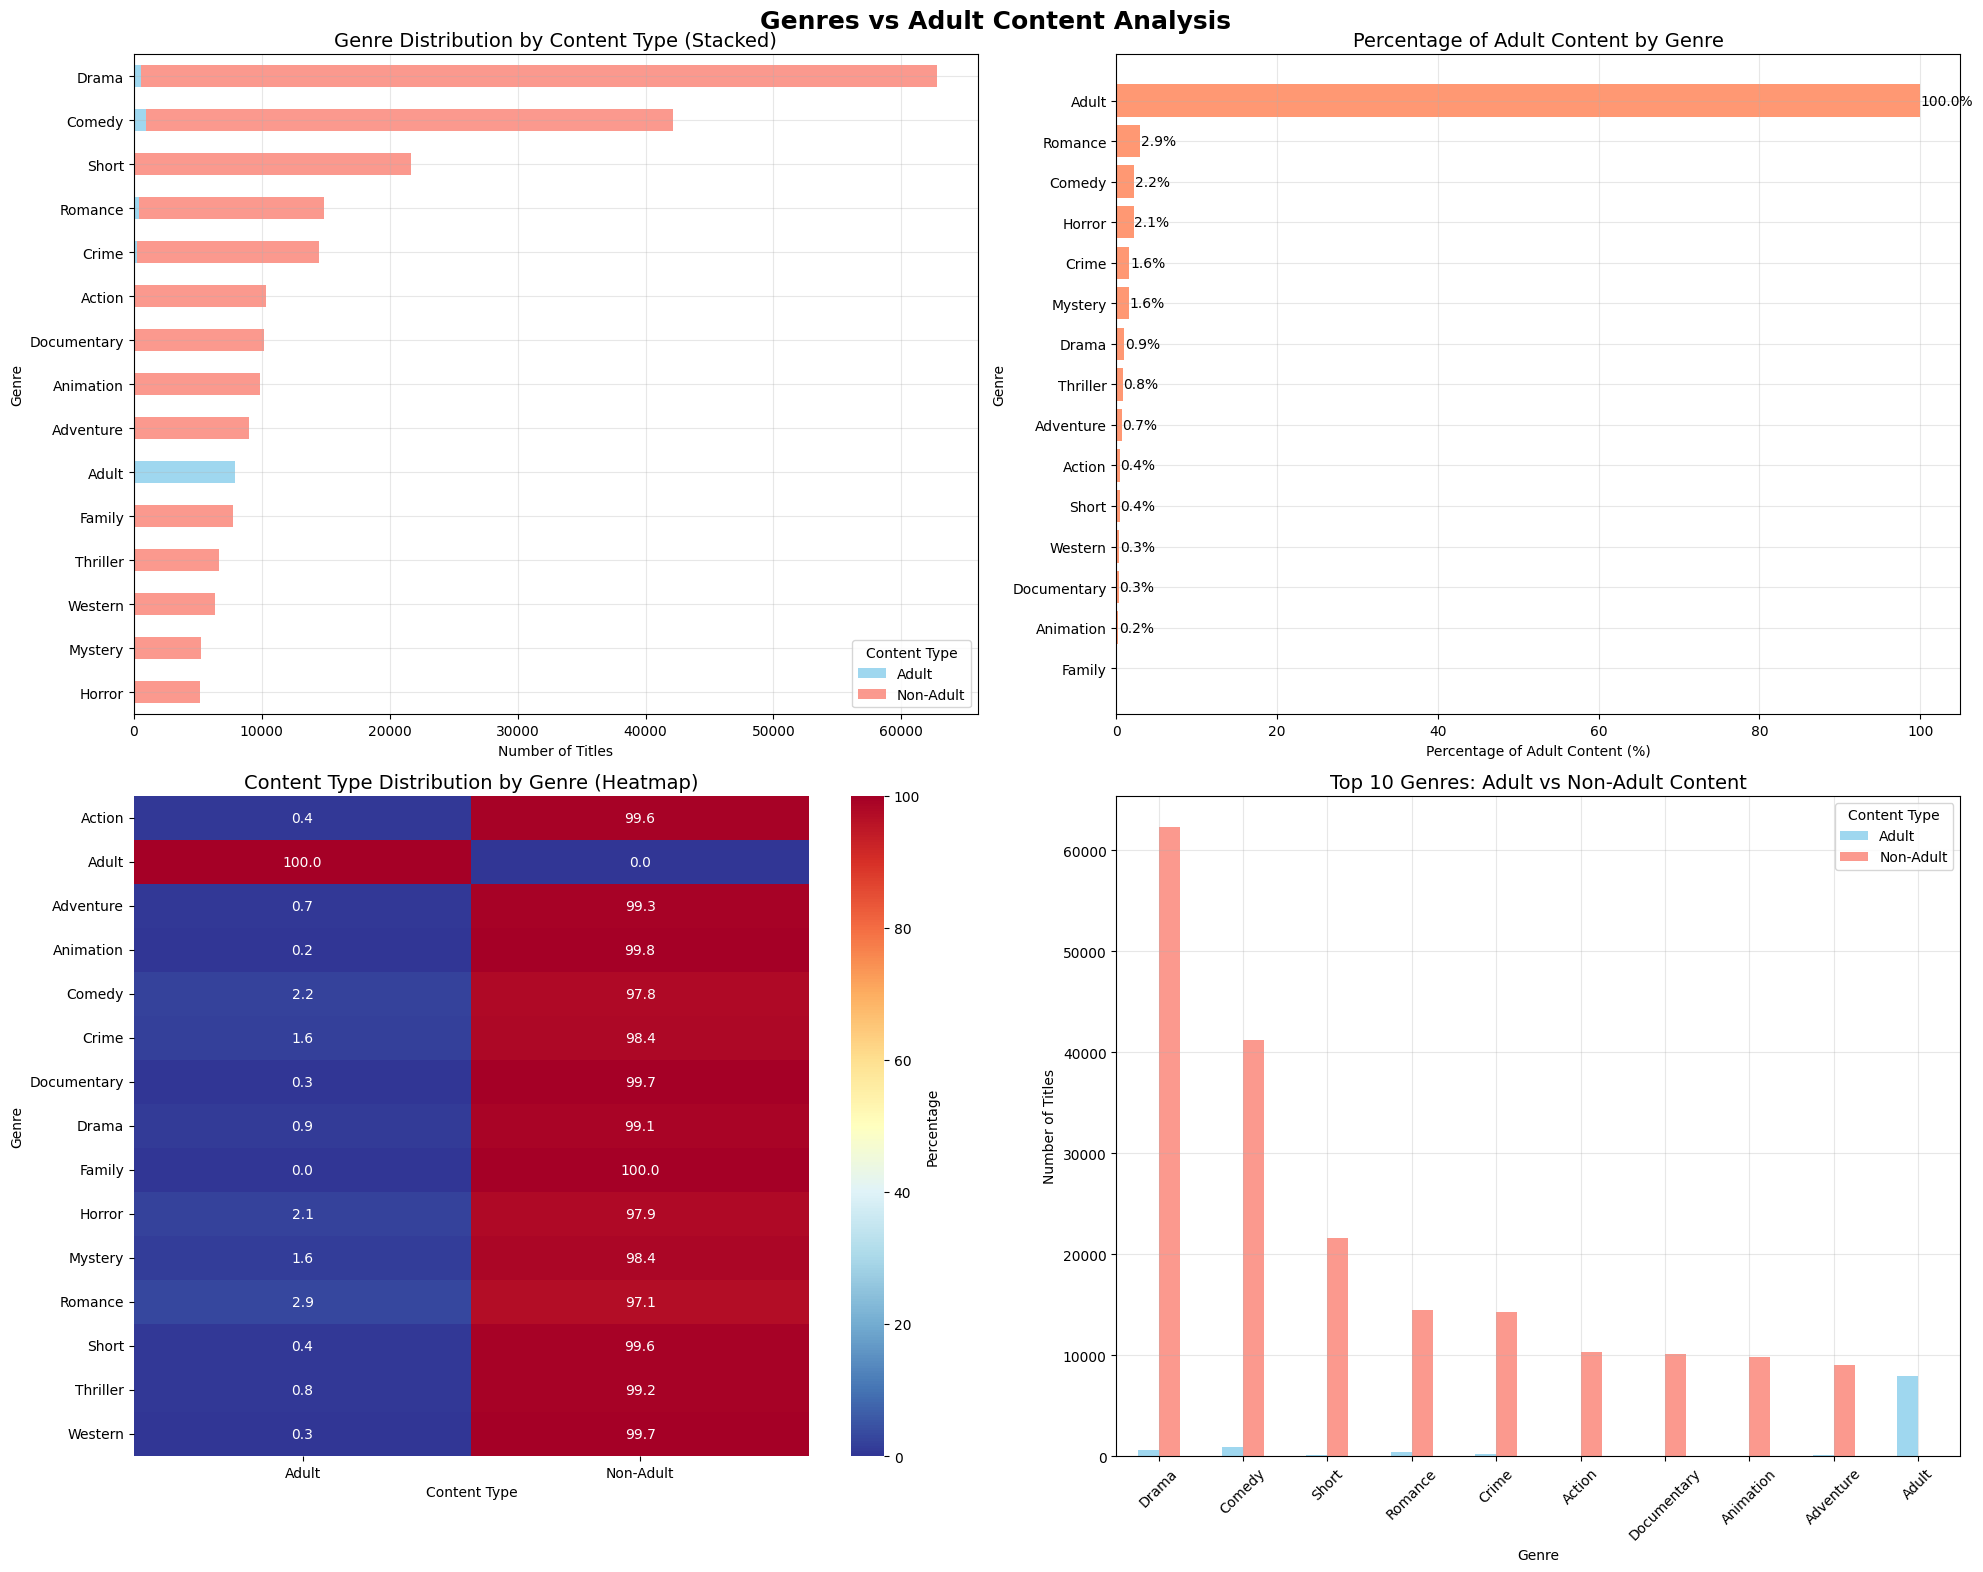


DETAILED GENRE vs ADULT CONTENT STATISTICS

Overall Statistics:
Total titles: 140,380
Adult titles: 8,030 (5.72%)
Non-adult titles: 132,350 (94.28%)

Genre Analysis:
Total unique genres: 28
Most common genre: Drama (62,820 titles)

Adult Content by Genre (Top 15):
             Total_Titles  Adult_Titles  Adult_Percentage
genre                                                    
Adult                7944          7943             100.0
Romance             14857           435               2.9
Comedy              42125           925               2.2
Horror               5149           110               2.1
Crime               14508           235               1.6
Mystery              5262            82               1.6
Drama               62820           581               0.9
Thriller             6641            51               0.8
Adventure            9023            59               0.7
Action              10307            43               0.4
Short               21668            8

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

def create_genres_adult_visualization():
    """
    Create visualization comparing genres with adult content classification
    """
    
    # Load multiple chunks to get diverse data
    print("Loading title_basics chunks to analyze genres vs adult content...")
    
    combined_data = None
    chunks_loaded = 0
    max_chunks_to_try = 3
    
    for chunk_num in range(1, max_chunks_to_try + 1):
        try:
            # Load title_basics chunk (contains both genres and isAdult)
            basics_chunk = pd.read_parquet(f"chunks/title_basic/title_basic_chunk_{chunk_num:03d}.parquet")
            
            # Select relevant columns
            chunk_data = basics_chunk[['tconst', 'genres', 'isAdult']].copy()
            
            if combined_data is None:
                combined_data = chunk_data
            else:
                combined_data = pd.concat([combined_data, chunk_data], ignore_index=True)
            
            chunks_loaded += 1
            print(f"Loaded chunk {chunk_num}: {len(chunk_data):,} rows")
            
            # Stop if we have enough data
            if len(combined_data) > 150000:
                print(f"Sufficient data collected after {chunks_loaded} chunks")
                break
                
        except FileNotFoundError:
            print(f"Chunk {chunk_num} not found")
            break
        except Exception as e:
            print(f"Error loading chunk {chunk_num}: {e}")
            continue
    
    if combined_data is None or len(combined_data) == 0:
        print("No data loaded successfully")
        return None
    
    print(f"\nTotal data loaded: {len(combined_data):,} rows")
    
    # Data preprocessing
    print("Preprocessing data...")
    
    # Convert isAdult to integer if it's string
    if combined_data['isAdult'].dtype == 'object':
        combined_data['isAdult'] = combined_data['isAdult'].astype(int)
    
    # Remove rows with missing genres
    combined_data = combined_data.dropna(subset=['genres'])
    combined_data = combined_data[combined_data['genres'] != '\\N']
    
    print(f"After removing missing genres: {len(combined_data):,} rows")
    
    # Check adult content distribution
    adult_counts = combined_data['isAdult'].value_counts()
    print(f"Adult content distribution: {dict(adult_counts)}")
    
    # Process genres (they are comma-separated)
    print("Processing genres...")
    
    # Split genres and create expanded dataset
    expanded_rows = []
    for idx, row in combined_data.iterrows():
        genres_list = [g.strip() for g in str(row['genres']).split(',') if g.strip()]
        for genre in genres_list:
            expanded_rows.append({
                'tconst': row['tconst'],
                'genre': genre,
                'isAdult': row['isAdult']
            })
    
    expanded_data = pd.DataFrame(expanded_rows)
    print(f"Expanded data with individual genres: {len(expanded_data):,} rows")
    
    # Get top genres
    genre_counts = expanded_data['genre'].value_counts()
    top_genres = genre_counts.head(15)  # Top 15 genres
    
    print(f"\nTop 15 genres:")
    for genre, count in top_genres.items():
        print(f"  {genre}: {count:,}")
    
    # Filter data to top genres only
    filtered_data = expanded_data[expanded_data['genre'].isin(top_genres.index)].copy()
    
    # Create adult content labels
    filtered_data['adult_label'] = filtered_data['isAdult'].map({0: 'Non-Adult', 1: 'Adult'})
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Genres vs Adult Content Analysis', fontsize=18, fontweight='bold')
    
    # 1. Stacked bar chart: Genre distribution by adult content
    ax1 = axes[0, 0]
    
    # Calculate genre-adult crosstab
    genre_adult_crosstab = pd.crosstab(filtered_data['genre'], filtered_data['adult_label'])
    
    # Sort by total count
    genre_adult_crosstab['total'] = genre_adult_crosstab.sum(axis=1)
    genre_adult_crosstab = genre_adult_crosstab.sort_values('total', ascending=True)
    genre_adult_crosstab = genre_adult_crosstab.drop('total', axis=1)
    
    genre_adult_crosstab.plot(kind='barh', stacked=True, ax=ax1, 
                             color=['skyblue', 'salmon'], alpha=0.8)
    ax1.set_title('Genre Distribution by Content Type (Stacked)', fontsize=14)
    ax1.set_xlabel('Number of Titles')
    ax1.set_ylabel('Genre')
    ax1.legend(title='Content Type')
    ax1.grid(True, alpha=0.3)
    
    # 2. Percentage of adult content by genre
    ax2 = axes[0, 1]
    
    # Calculate adult percentage by genre
    genre_adult_pct = filtered_data.groupby('genre')['isAdult'].agg(['count', 'sum']).reset_index()
    genre_adult_pct['adult_percentage'] = (genre_adult_pct['sum'] / genre_adult_pct['count']) * 100
    genre_adult_pct = genre_adult_pct.sort_values('adult_percentage', ascending=True)
    
    bars = ax2.barh(genre_adult_pct['genre'], genre_adult_pct['adult_percentage'], 
                    color='coral', alpha=0.8)
    ax2.set_title('Percentage of Adult Content by Genre', fontsize=14)
    ax2.set_xlabel('Percentage of Adult Content (%)')
    ax2.set_ylabel('Genre')
    ax2.grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for bar, pct in zip(bars, genre_adult_pct['adult_percentage']):
        if pct > 0:
            ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                    f'{pct:.1f}%', ha='left', va='center', fontsize=10)
    
    # 3. Heatmap of genre vs adult content
    ax3 = axes[1, 0]
    
    # Create heatmap data
    heatmap_data = pd.crosstab(filtered_data['genre'], filtered_data['adult_label'], normalize='index') * 100
    
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlBu_r', 
                ax=ax3, cbar_kws={'label': 'Percentage'})
    ax3.set_title('Content Type Distribution by Genre (Heatmap)', fontsize=14)
    ax3.set_xlabel('Content Type')
    ax3.set_ylabel('Genre')
    
    # 4. Top genres comparison
    ax4 = axes[1, 1]
    
    # Get top 10 genres and their adult content stats
    top_10_genres = genre_counts.head(10).index
    top_10_data = filtered_data[filtered_data['genre'].isin(top_10_genres)]
    
    # Create grouped bar chart
    top_10_crosstab = pd.crosstab(top_10_data['genre'], top_10_data['adult_label'])
    top_10_crosstab = top_10_crosstab.reindex(top_10_genres)
    
    top_10_crosstab.plot(kind='bar', ax=ax4, color=['skyblue', 'salmon'], alpha=0.8)
    ax4.set_title('Top 10 Genres: Adult vs Non-Adult Content', fontsize=14)
    ax4.set_xlabel('Genre')
    ax4.set_ylabel('Number of Titles')
    ax4.legend(title='Content Type')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*70)
    print("DETAILED GENRE vs ADULT CONTENT STATISTICS")
    print("="*70)
    
    # Overall statistics
    total_titles = len(combined_data)
    adult_titles = len(combined_data[combined_data['isAdult'] == 1])
    non_adult_titles = len(combined_data[combined_data['isAdult'] == 0])
    
    print(f"\nOverall Statistics:")
    print(f"Total titles: {total_titles:,}")
    print(f"Adult titles: {adult_titles:,} ({adult_titles/total_titles*100:.2f}%)")
    print(f"Non-adult titles: {non_adult_titles:,} ({non_adult_titles/total_titles*100:.2f}%)")
    
    # Genre statistics
    print(f"\nGenre Analysis:")
    print(f"Total unique genres: {len(genre_counts)}")
    print(f"Most common genre: {genre_counts.index[0]} ({genre_counts.iloc[0]:,} titles)")
    
    # Adult content by genre statistics
    print(f"\nAdult Content by Genre (Top 15):")
    adult_by_genre = filtered_data.groupby('genre').agg({
        'isAdult': ['count', 'sum', 'mean']
    }).round(3)
    adult_by_genre.columns = ['Total_Titles', 'Adult_Titles', 'Adult_Percentage']
    adult_by_genre['Adult_Percentage'] = adult_by_genre['Adult_Percentage'] * 100
    adult_by_genre = adult_by_genre.sort_values('Adult_Percentage', ascending=False)
    
    print(adult_by_genre.head(15))
    
    # Find genres with highest adult content percentage
    high_adult_genres = adult_by_genre[adult_by_genre['Adult_Percentage'] > 0].head(5)
    if len(high_adult_genres) > 0:
        print(f"\nGenres with Highest Adult Content Percentage:")
        for genre, row in high_adult_genres.iterrows():
            print(f"  {genre}: {row['Adult_Percentage']:.1f}% ({int(row['Adult_Titles'])}/{int(row['Total_Titles'])})")
    
    return combined_data, expanded_data

def analyze_genre_combinations():
    """
    Additional analysis for genre combinations in adult vs non-adult content
    """
    print("\n" + "="*70)
    print("GENRE COMBINATION ANALYSIS")
    print("="*70)
    
    # This function can be called separately to analyze multi-genre titles
    pass

# Main execution
if __name__ == "__main__":
    print("Creating Genres vs Adult Content Visualization")
    print("="*70)
    
    try:
        original_data, expanded_data = create_genres_adult_visualization()
        print(f"\nAnalysis completed successfully!")
        print(f"Original data: {len(original_data):,} titles")
        print(f"Expanded data: {len(expanded_data):,} genre-title pairs")
        
    except Exception as e:
        print(f"Error in analysis: {e}")
        import traceback
        traceback.print_exc()

Creating Genres vs Runtime Minutes Visualization
Loading title_basics chunks to analyze genres vs runtime...
Loaded chunk 1: 50,000 rows
Loaded chunk 2: 50,000 rows
Loaded chunk 3: 50,000 rows

Total data loaded: 150,000 rows
Preprocessing data...
After preprocessing: 122,684 rows
Runtime range: 1 - 600 minutes
Processing genres...
Expanded data with individual genres: 232,212 rows

Top 15 genres (with sufficient data):
  Drama: 57,583 titles (avg: 89.0 min)
  Comedy: 38,099 titles (avg: 69.7 min)
  Short: 15,286 titles (avg: 15.2 min)
  Romance: 14,071 titles (avg: 89.1 min)
  Crime: 13,856 titles (avg: 87.5 min)
  Action: 9,808 titles (avg: 92.7 min)
  Adventure: 8,560 titles (avg: 87.0 min)
  Animation: 7,946 titles (avg: 16.0 min)
  Documentary: 7,515 titles (avg: 52.3 min)
  Family: 7,495 titles (avg: 47.4 min)
  Thriller: 6,407 titles (avg: 94.7 min)
  Western: 5,581 titles (avg: 70.0 min)
  Adult: 5,504 titles (avg: 77.4 min)
  Mystery: 5,038 titles (avg: 87.7 min)
  Horror: 4,9

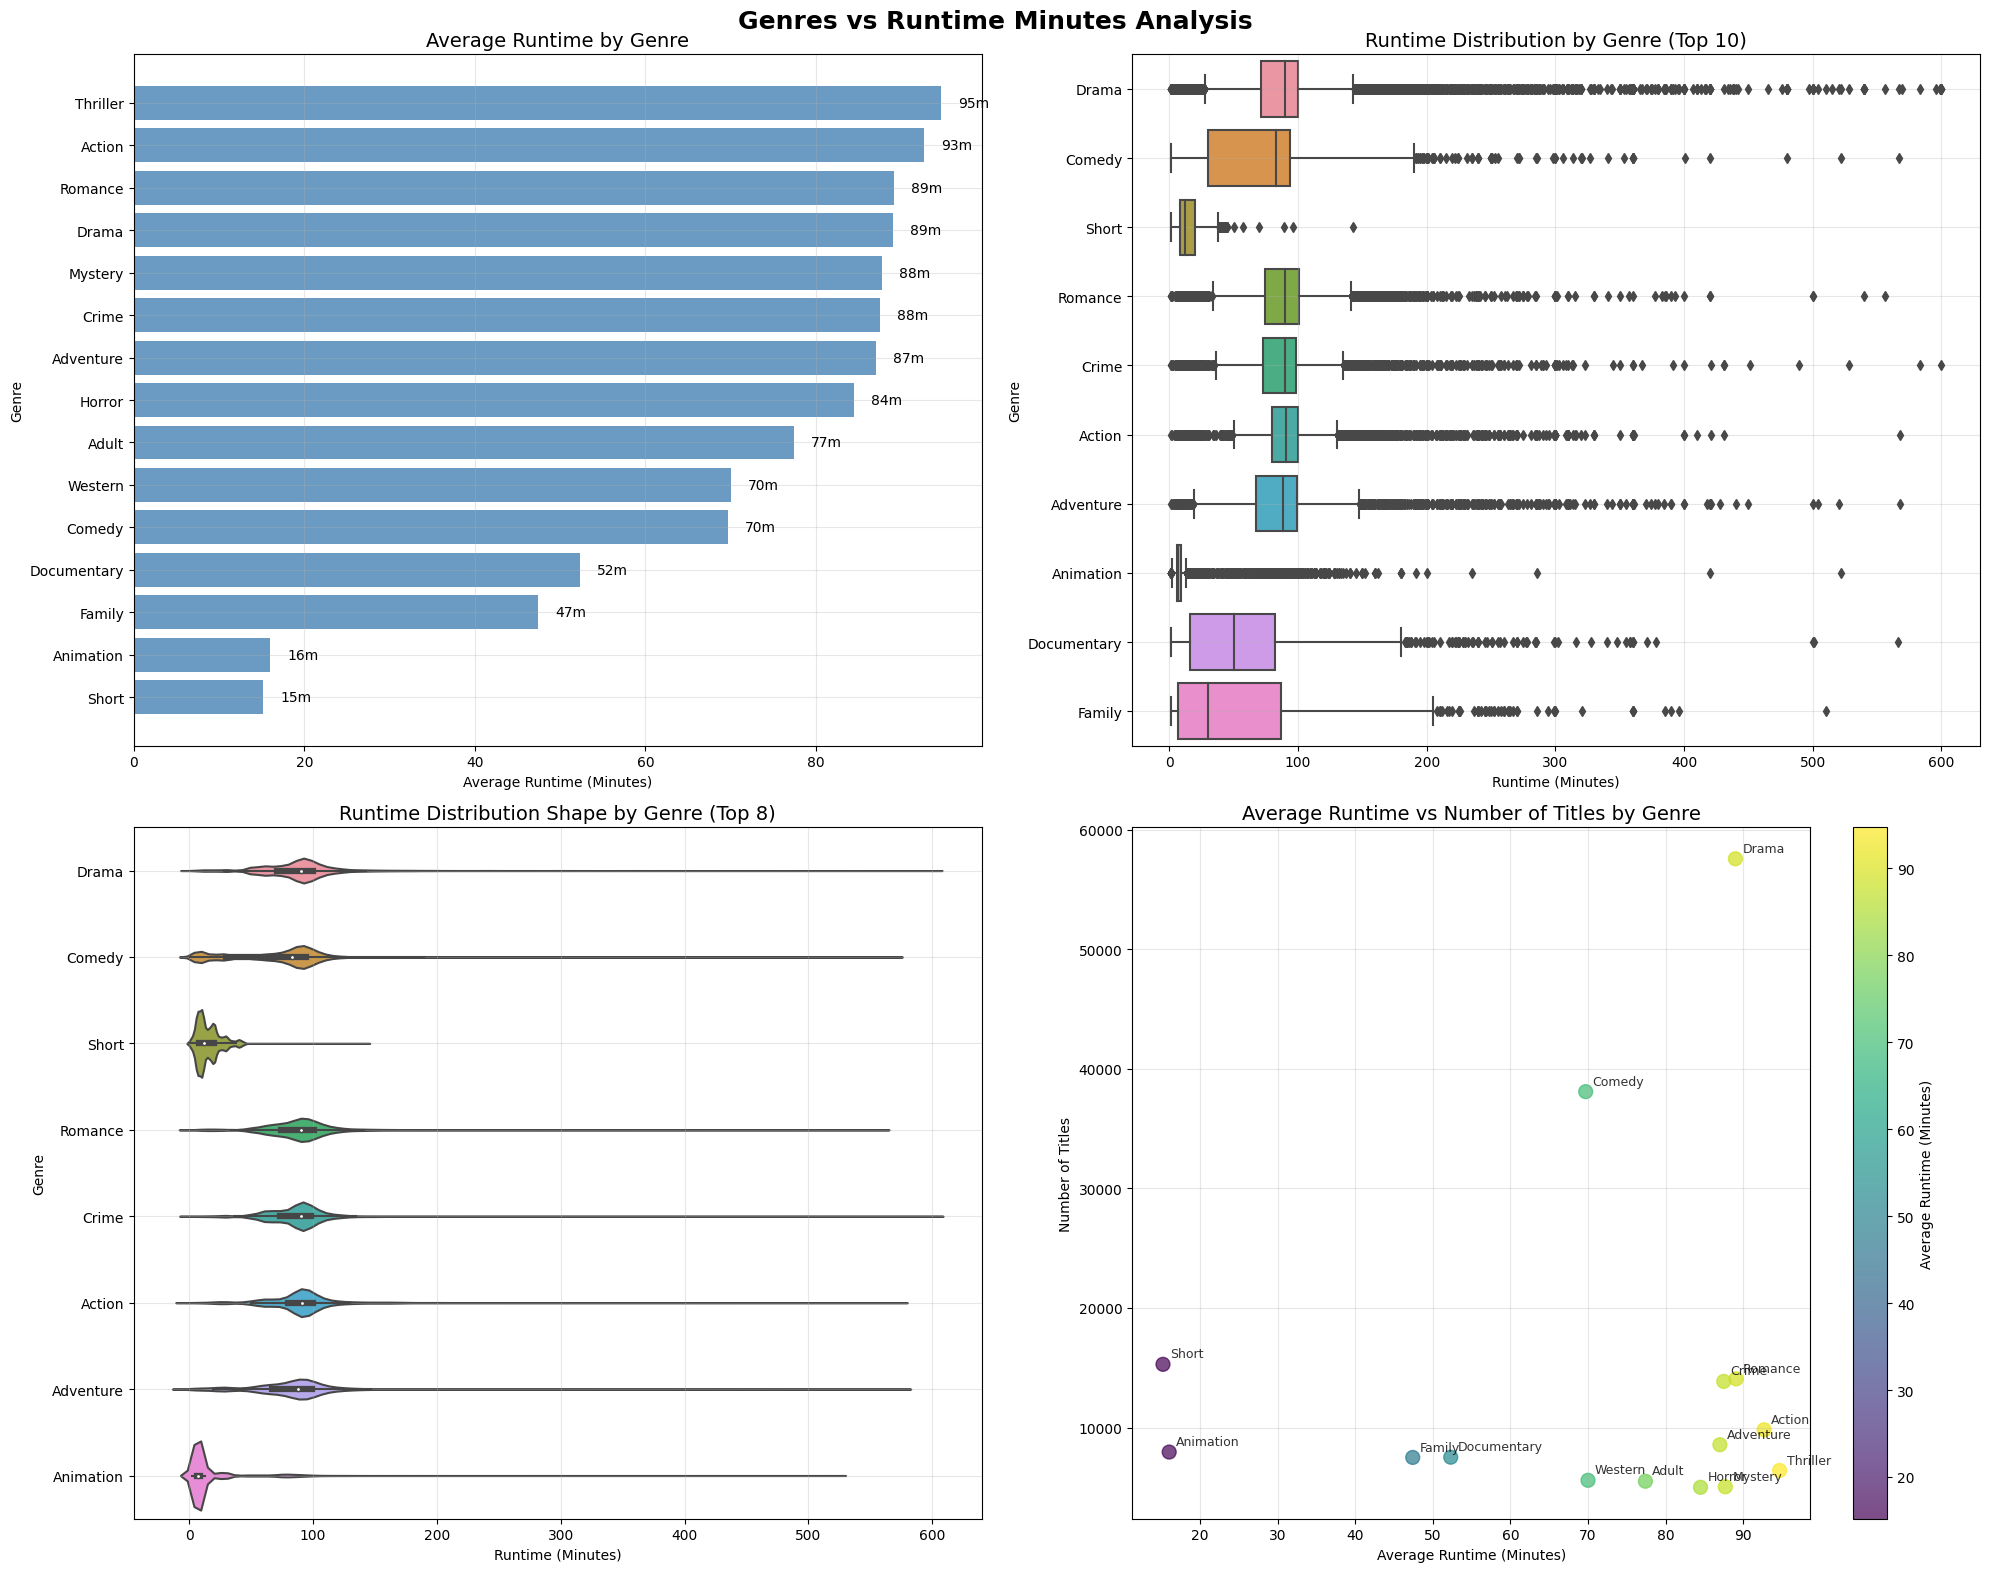


Creating runtime range analysis...


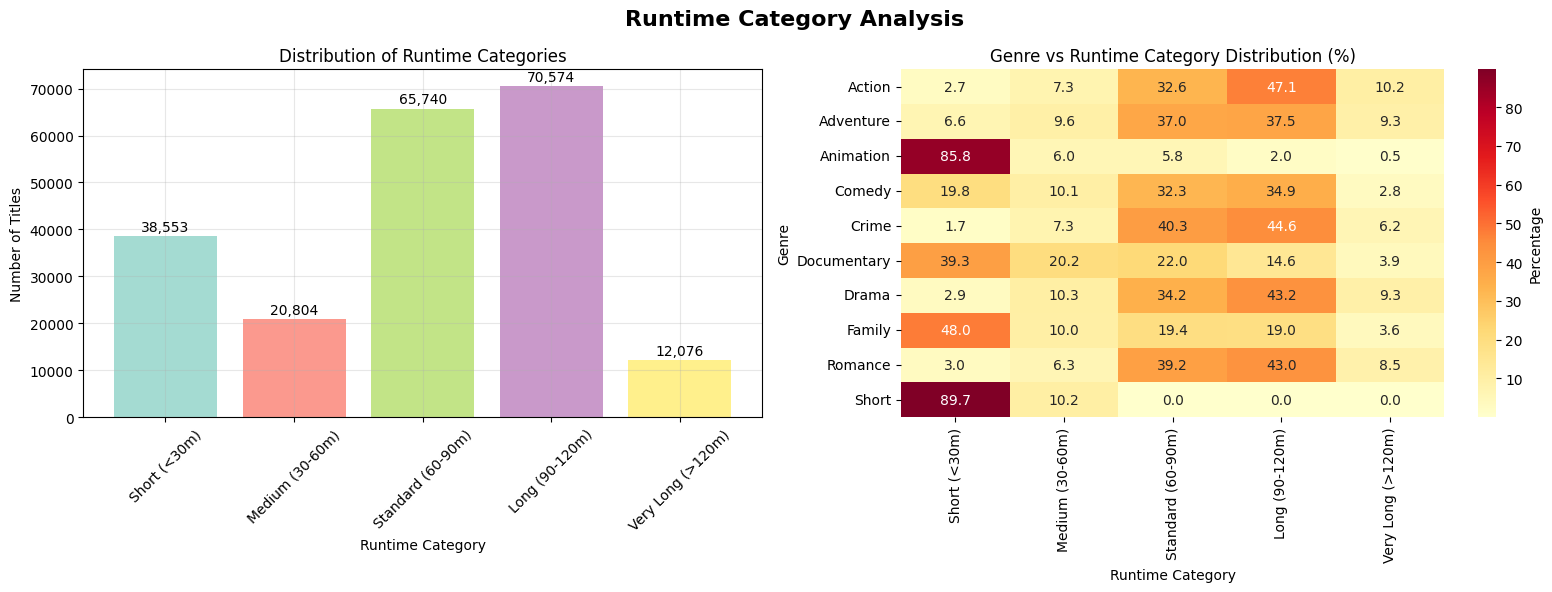


DETAILED GENRE vs RUNTIME STATISTICS

Overall Runtime Statistics:
Total titles with runtime data: 122,684
Mean runtime: 75.9 minutes
Median runtime: 84.0 minutes
Standard deviation: 39.7 minutes
Range: 1 - 600 minutes

Runtime Statistics by Genre (Top 15):
Genre           Count    Mean     Median   Std      Min    Max   
------------------------------------------------------------------------------------------
Thriller        6407     94.7     93.0     27.6     3      600   
Action          9808     92.7     91.0     37.3     1      568   
Romance         14071    89.1     90.0     30.7     1      556   
Drama           57583    89.0     90.0     35.3     1      600   
Mystery         5038     87.7     89.0     30.2     3      440   
Crime           13856    87.5     90.0     29.4     1      600   
Adventure       8560     87.0     88.0     44.7     1      568   
Horror          4998     84.5     88.0     22.3     1      300   
Adult           5504     77.4     77.0     15.5     5    

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

def create_genres_runtime_visualization():
    """
    Create visualization comparing genres with runtime minutes
    """
    
    # Load multiple chunks to get diverse data
    print("Loading title_basics chunks to analyze genres vs runtime...")
    
    combined_data = None
    chunks_loaded = 0
    max_chunks_to_try = 3
    
    for chunk_num in range(1, max_chunks_to_try + 1):
        try:
            # Load title_basics chunk (contains both genres and runtimeMinutes)
            basics_chunk = pd.read_parquet(f"chunks/title_basic/title_basic_chunk_{chunk_num:03d}.parquet")
            
            # Select relevant columns
            chunk_data = basics_chunk[['tconst', 'titleType', 'genres', 'runtimeMinutes']].copy()
            
            if combined_data is None:
                combined_data = chunk_data
            else:
                combined_data = pd.concat([combined_data, chunk_data], ignore_index=True)
            
            chunks_loaded += 1
            print(f"Loaded chunk {chunk_num}: {len(chunk_data):,} rows")
            
            # Stop if we have enough data
            if len(combined_data) > 150000:
                print(f"Sufficient data collected after {chunks_loaded} chunks")
                break
                
        except FileNotFoundError:
            print(f"Chunk {chunk_num} not found")
            break
        except Exception as e:
            print(f"Error loading chunk {chunk_num}: {e}")
            continue
    
    if combined_data is None or len(combined_data) == 0:
        print("No data loaded successfully")
        return None
    
    print(f"\nTotal data loaded: {len(combined_data):,} rows")
    
    # Data preprocessing
    print("Preprocessing data...")
    
    # Remove rows with missing genres or invalid runtime
    combined_data = combined_data.dropna(subset=['genres', 'runtimeMinutes'])
    combined_data = combined_data[combined_data['genres'] != '\\N']
    combined_data = combined_data[combined_data['runtimeMinutes'] != '\\N']
    
    # Convert runtimeMinutes to numeric, handle any conversion errors
    combined_data['runtimeMinutes'] = pd.to_numeric(combined_data['runtimeMinutes'], errors='coerce')
    combined_data = combined_data.dropna(subset=['runtimeMinutes'])
    
    # Filter out unrealistic runtimeMinutes (less than 1 minute or more than 600 minutes)
    combined_data = combined_data[
        (combined_data['runtimeMinutes'] >= 1) & 
        (combined_data['runtimeMinutes'] <= 600)
    ]
    
    print(f"After preprocessing: {len(combined_data):,} rows")
    print(f"Runtime range: {combined_data['runtimeMinutes'].min():.0f} - {combined_data['runtimeMinutes'].max():.0f} minutes")
    
    # Process genres (they are comma-separated)
    print("Processing genres...")
    
    # Split genres and create expanded dataset
    expanded_rows = []
    for idx, row in combined_data.iterrows():
        genres_list = [g.strip() for g in str(row['genres']).split(',') if g.strip()]
        for genre in genres_list:
            expanded_rows.append({
                'tconst': row['tconst'],
                'titleType': row['titleType'],
                'genre': genre,
                'runtimeMinutes': row['runtimeMinutes']
            })
    
    expanded_data = pd.DataFrame(expanded_rows)
    print(f"Expanded data with individual genres: {len(expanded_data):,} rows")
    
    # Get top genres with sufficient data
    genre_counts = expanded_data['genre'].value_counts()
    top_genres = genre_counts[genre_counts >= 100].head(15)  # Top 15 genres with at least 100 titles
    
    print(f"\nTop 15 genres (with sufficient data):")
    for genre, count in top_genres.items():
        avg_runtime = expanded_data[expanded_data['genre'] == genre]['runtimeMinutes'].mean()
        print(f"  {genre}: {count:,} titles (avg: {avg_runtime:.1f} min)")
    
    # Filter data to top genres only
    filtered_data = expanded_data[expanded_data['genre'].isin(top_genres.index)].copy()
    
    # Calculate average runtime by genre
    genre_runtime_stats = filtered_data.groupby('genre')['runtimeMinutes'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(1)
    genre_runtime_stats = genre_runtime_stats.sort_values('mean', ascending=False)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Genres vs Runtime Minutes Analysis', fontsize=18, fontweight='bold')
    
    # 1. Average runtime by genre (horizontal bar chart)
    ax1 = axes[0, 0]
    
    avg_runtime_sorted = genre_runtime_stats.sort_values('mean', ascending=True)
    bars = ax1.barh(avg_runtime_sorted.index, avg_runtime_sorted['mean'], 
                    color='steelblue', alpha=0.8)
    ax1.set_title('Average Runtime by Genre', fontsize=14)
    ax1.set_xlabel('Average Runtime (Minutes)')
    ax1.set_ylabel('Genre')
    ax1.grid(True, alpha=0.3)
    
    # Add runtime labels on bars
    for bar, runtime in zip(bars, avg_runtime_sorted['mean']):
        ax1.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
                f'{runtime:.0f}m', ha='left', va='center', fontsize=10)
    
    # 2. Box plot of runtime distribution by genre
    ax2 = axes[0, 1]
    
    # Get top 10 genres for box plot (to avoid overcrowding)
    top_10_genres = top_genres.head(10).index
    box_data = filtered_data[filtered_data['genre'].isin(top_10_genres)]
    
    sns.boxplot(data=box_data, y='genre', x='runtimeMinutes', ax=ax2, 
                order=top_10_genres)
    ax2.set_title('Runtime Distribution by Genre (Top 10)', fontsize=14)
    ax2.set_xlabel('Runtime (Minutes)')
    ax2.set_ylabel('Genre')
    ax2.grid(True, alpha=0.3)
    
    # 3. Violin plot for runtime distribution
    ax3 = axes[1, 0]
    
    # Use top 8 genres for violin plot
    top_8_genres = top_genres.head(8).index
    violin_data = filtered_data[filtered_data['genre'].isin(top_8_genres)]
    
    sns.violinplot(data=violin_data, y='genre', x='runtimeMinutes', ax=ax3,
                   order=top_8_genres)
    ax3.set_title('Runtime Distribution Shape by Genre (Top 8)', fontsize=14)
    ax3.set_xlabel('Runtime (Minutes)')
    ax3.set_ylabel('Genre')
    ax3.grid(True, alpha=0.3)
    
    # 4. Runtime vs Genre Count scatter plot
    ax4 = axes[1, 1]
    
    # Create scatter plot of average runtime vs number of titles
    scatter_data = genre_runtime_stats.copy()
    scatter_data['log_count'] = np.log10(scatter_data['count'])
    
    scatter = ax4.scatter(scatter_data['mean'], scatter_data['count'], 
                         s=100, alpha=0.7, c=scatter_data['mean'], 
                         cmap='viridis')
    
    # Add genre labels to points
    for idx, (genre, row) in enumerate(scatter_data.iterrows()):
        ax4.annotate(genre, (row['mean'], row['count']), 
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, alpha=0.8)
    
    ax4.set_title('Average Runtime vs Number of Titles by Genre', fontsize=14)
    ax4.set_xlabel('Average Runtime (Minutes)')
    ax4.set_ylabel('Number of Titles')
    ax4.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Average Runtime (Minutes)')
    
    plt.tight_layout()
    plt.show()
    
    # Create additional runtime range analysis
    create_runtime_range_analysis(filtered_data, top_genres)
    
    # Print detailed statistics
    print("\n" + "="*70)
    print("DETAILED GENRE vs RUNTIME STATISTICS")
    print("="*70)
    
    # Overall statistics
    print(f"\nOverall Runtime Statistics:")
    overall_stats = combined_data['runtimeMinutes'].describe()
    print(f"Total titles with runtime data: {len(combined_data):,}")
    print(f"Mean runtime: {overall_stats['mean']:.1f} minutes")
    print(f"Median runtime: {overall_stats['50%']:.1f} minutes")
    print(f"Standard deviation: {overall_stats['std']:.1f} minutes")
    print(f"Range: {overall_stats['min']:.0f} - {overall_stats['max']:.0f} minutes")
    
    # Genre-specific statistics
    print(f"\nRuntime Statistics by Genre (Top 15):")
    print("="*90)
    print(f"{'Genre':<15} {'Count':<8} {'Mean':<8} {'Median':<8} {'Std':<8} {'Min':<6} {'Max':<6}")
    print("-" * 90)
    
    for genre, stats in genre_runtime_stats.head(15).iterrows():
        print(f"{genre:<15} {stats['count']:<8.0f} {stats['mean']:<8.1f} "
              f"{stats['median']:<8.1f} {stats['std']:<8.1f} {stats['min']:<6.0f} {stats['max']:<6.0f}")
    
    # Find interesting patterns
    print(f"\nInteresting Patterns:")
    longest_avg = genre_runtime_stats.iloc[0]
    shortest_avg = genre_runtime_stats.iloc[-1]
    print(f"Longest average runtime: {longest_avg.name} ({longest_avg['mean']:.1f} minutes)")
    print(f"Shortest average runtime: {shortest_avg.name} ({shortest_avg['mean']:.1f} minutes)")
    
    # Most variable genres
    most_variable = genre_runtime_stats.nlargest(3, 'std')
    print(f"\nMost variable runtime genres:")
    for genre, stats in most_variable.iterrows():
        print(f"  {genre}: {stats['std']:.1f} minutes std dev (mean: {stats['mean']:.1f}m)")
    
    return combined_data, expanded_data, genre_runtime_stats

def create_runtime_range_analysis(filtered_data, top_genres):
    """
    Create additional analysis of runtime ranges
    """
    print("\nCreating runtime range analysis...")
    
    # Define runtime categories
    def categorize_runtime(minutes):
        if minutes < 30:
            return "Short (<30m)"
        elif minutes < 60:
            return "Medium (30-60m)"
        elif minutes < 90:
            return "Standard (60-90m)"
        elif minutes < 120:
            return "Long (90-120m)"
        else:
            return "Very Long (>120m)"
    
    # Add runtime categories
    filtered_data['runtime_category'] = filtered_data['runtimeMinutes'].apply(categorize_runtime)
    
    # Create runtime category analysis
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Runtime Category Analysis', fontsize=16, fontweight='bold')
    
    # 1. Runtime category distribution
    ax1 = axes[0]
    runtime_cat_counts = filtered_data['runtime_category'].value_counts()
    
    # Reorder categories logically
    category_order = ["Short (<30m)", "Medium (30-60m)", "Standard (60-90m)", 
                     "Long (90-120m)", "Very Long (>120m)"]
    runtime_cat_counts = runtime_cat_counts.reindex(category_order, fill_value=0)
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(runtime_cat_counts)))
    bars = ax1.bar(runtime_cat_counts.index, runtime_cat_counts.values, 
                   color=colors, alpha=0.8)
    ax1.set_title('Distribution of Runtime Categories')
    ax1.set_xlabel('Runtime Category')
    ax1.set_ylabel('Number of Titles')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add count labels on bars
    for bar, count in zip(bars, runtime_cat_counts.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
                f'{count:,}', ha='center', va='bottom', fontsize=10)
    
    # 2. Genre vs runtime category heatmap
    ax2 = axes[1]
    
    # Create crosstab for top 10 genres
    top_10_for_heatmap = top_genres.head(10).index
    heatmap_data = filtered_data[filtered_data['genre'].isin(top_10_for_heatmap)]
    
    crosstab = pd.crosstab(heatmap_data['genre'], heatmap_data['runtime_category'])
    crosstab = crosstab.reindex(columns=category_order, fill_value=0)
    
    # Normalize by row to show percentages
    crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
    
    sns.heatmap(crosstab_pct, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2,
                cbar_kws={'label': 'Percentage'})
    ax2.set_title('Genre vs Runtime Category Distribution (%)')
    ax2.set_xlabel('Runtime Category')
    ax2.set_ylabel('Genre')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    print("Creating Genres vs Runtime Minutes Visualization")
    print("="*70)
    
    try:
        original_data, expanded_data, runtime_stats = create_genres_runtime_visualization()
        print(f"\nAnalysis completed successfully!")
        print(f"Original data: {len(original_data):,} titles")
        print(f"Expanded data: {len(expanded_data):,} genre-title pairs")
        print(f"Genre statistics calculated for {len(runtime_stats)} genres")
        
    except Exception as e:
        print(f"Error in analysis: {e}")
        import traceback
        traceback.print_exc()

Creating Genres vs Ratings and Votes Visualization
Loading data chunks to analyze genres vs ratings and votes...
Loading title_basics chunks...
Loaded title_basics chunk 1: 50,000 rows
Loaded title_basics chunk 2: 50,000 rows
Loaded title_basics chunk 3: 50,000 rows
Loading title_ratings chunks...
Loaded title_ratings chunk 1: 50,000 rows
Loaded title_ratings chunk 2: 50,000 rows
Loaded title_ratings chunk 3: 50,000 rows
Loaded basics data: 150,000 rows
Loaded ratings data: 150,000 rows
Merging datasets...
Merged dataset size: 111,202 rows
Preprocessing data...
After preprocessing: 108,536 rows
Rating range: 1.0 - 10.0
Votes range: 5 - 3,053,067
Processing genres...
Expanded data with individual genres: 211,696 rows

Top 15 genres (with sufficient data):
  Drama: 52,238 titles (avg rating: 6.27, avg votes: 3,817)
  Comedy: 35,474 titles (avg rating: 6.08, avg votes: 3,278)
  Crime: 13,269 titles (avg rating: 6.12, avg votes: 6,317)
  Romance: 13,040 titles (avg rating: 6.18, avg votes:

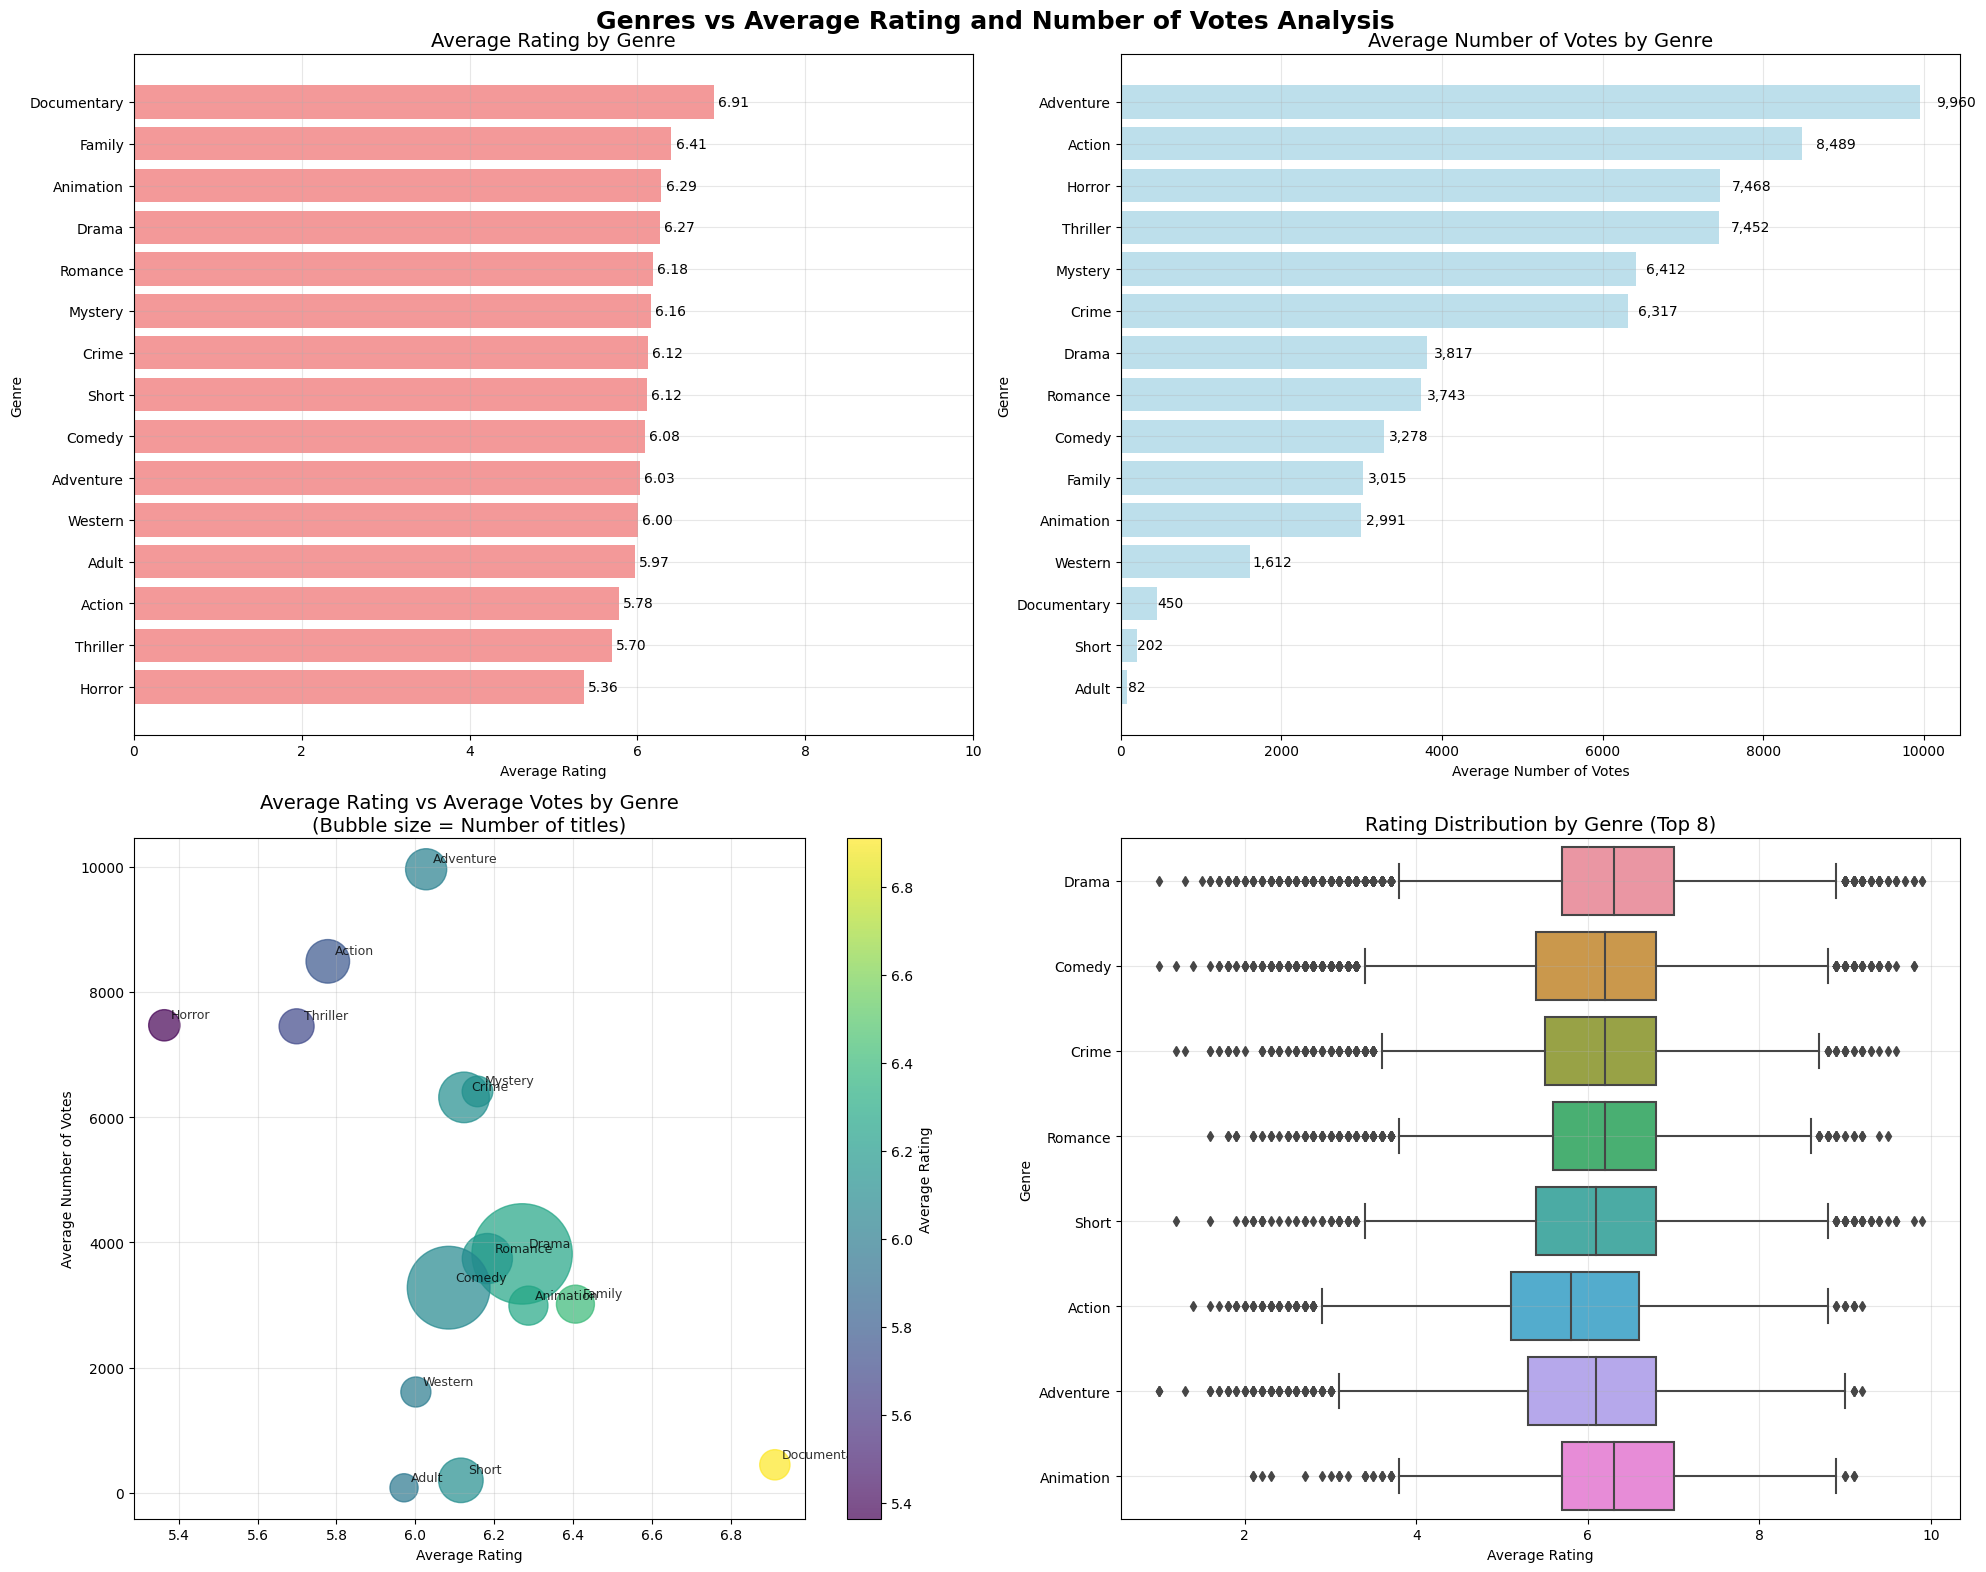


Creating detailed analysis visualizations...


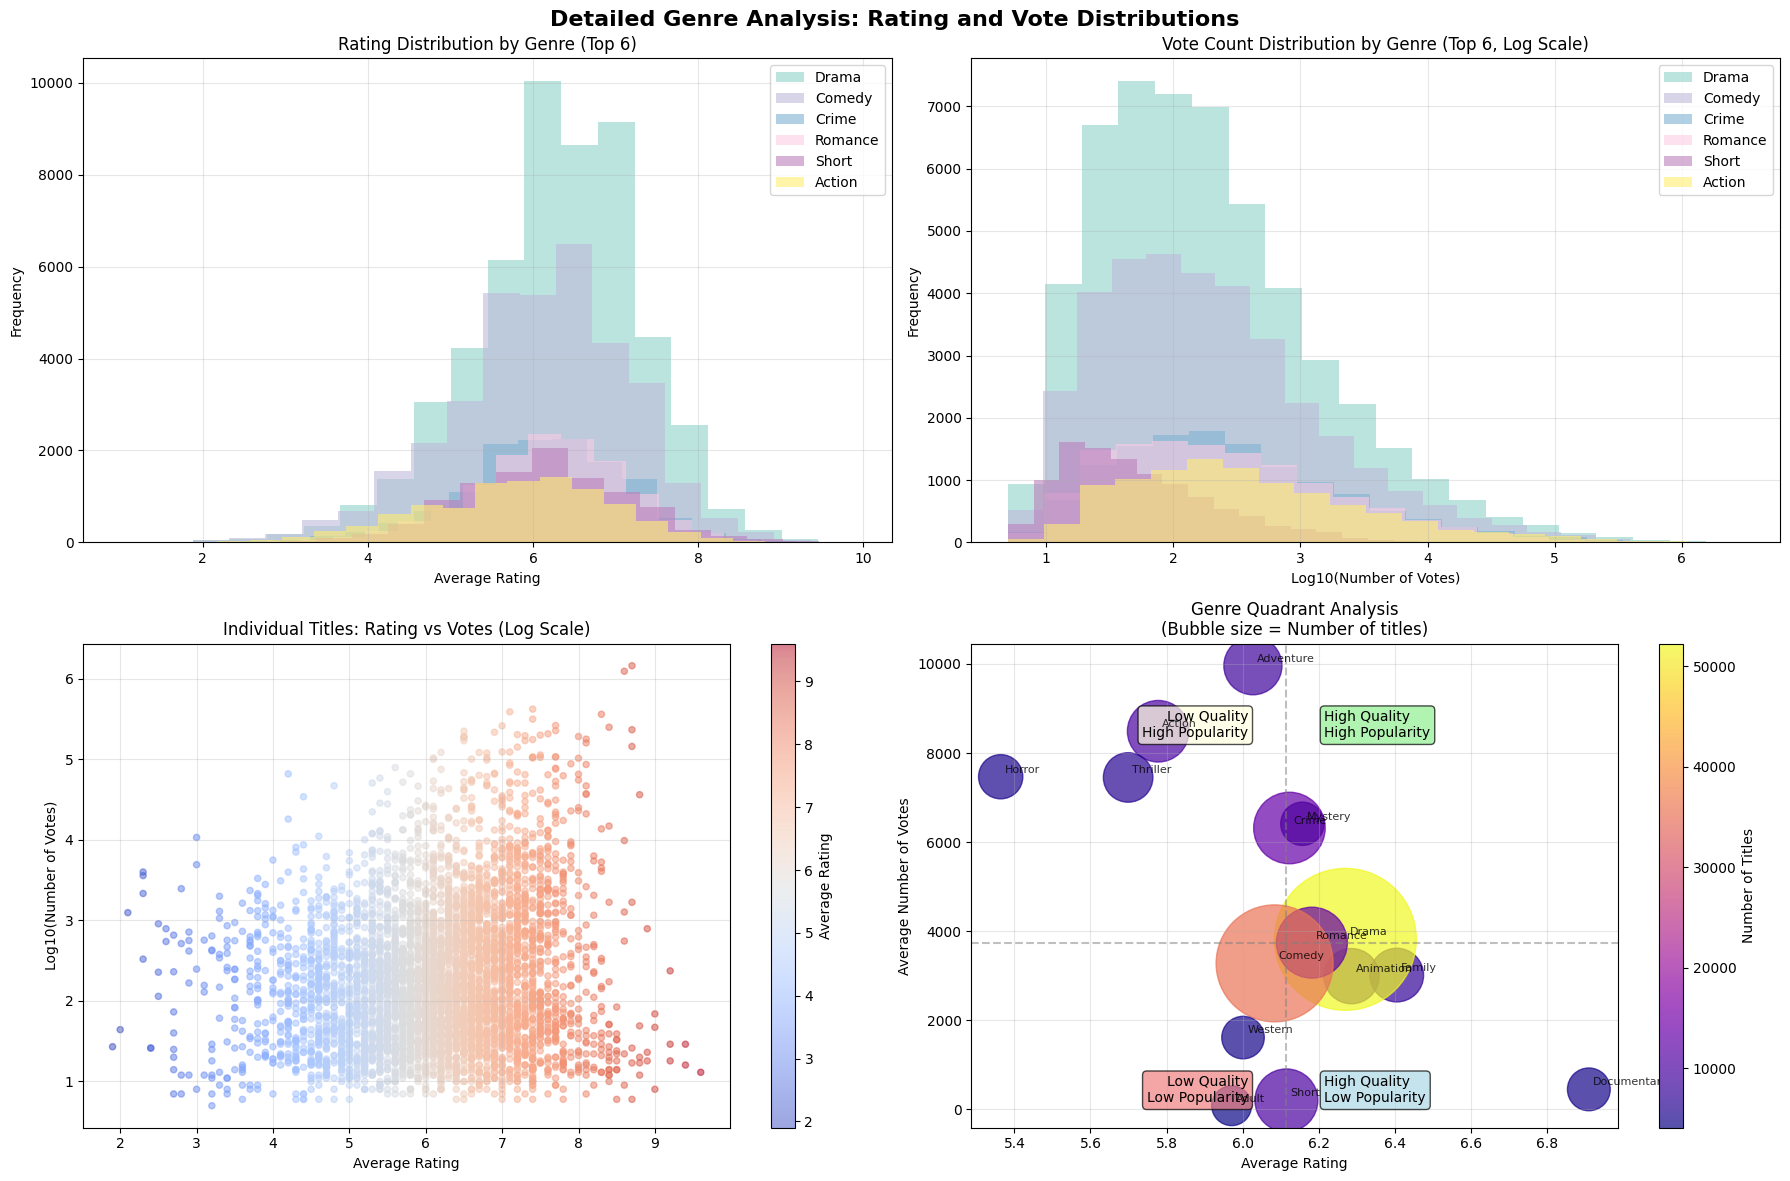


COMPREHENSIVE GENRE STATISTICS

Overall Statistics:
Total titles analyzed: 108,536
Unique genres: 28
Average rating across all titles: 6.14
Average votes across all titles: 3,404
Median votes: 117

Detailed Statistics by Genre (Top 15):
Genre           Count    Avg Rating   Rating Std   Avg Votes    Votes Std   
------------------------------------------------------------------------------------------------------------------------
Documentary     4750     6.91         1.07         450          2143        
Family          7485     6.41         0.94         3015         22073       
Animation       7919     6.29         0.91         2991         29958       
Drama           52238    6.27         1.01         3817         43054       
Romance         13040    6.18         0.94         3743         34400       
Mystery         4872     6.16         1.00         6412         46934       
Crime           13269    6.12         1.00         6317         60269       
Short           10277    

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

def create_genres_ratings_votes_visualization():
    """
    Create visualization comparing genres with average ratings and number of votes
    """
    
    # Load multiple chunks to get diverse data
    print("Loading data chunks to analyze genres vs ratings and votes...")
    
    # Load title_basics chunks for genres
    basics_data = None
    ratings_data = None
    
    max_chunks_to_try = 3
    
    # Load title_basics chunks
    print("Loading title_basics chunks...")
    for chunk_num in range(1, max_chunks_to_try + 1):
        try:
            basics_chunk = pd.read_parquet(f"chunks/title_basic/title_basic_chunk_{chunk_num:03d}.parquet")
            chunk_data = basics_chunk[['tconst', 'genres']].copy()
            
            if basics_data is None:
                basics_data = chunk_data
            else:
                basics_data = pd.concat([basics_data, chunk_data], ignore_index=True)
            
            print(f"Loaded title_basics chunk {chunk_num}: {len(chunk_data):,} rows")
            
            if len(basics_data) > 200000:
                break
                
        except FileNotFoundError:
            print(f"title_basics chunk {chunk_num} not found")
            break
        except Exception as e:
            print(f"Error loading title_basics chunk {chunk_num}: {e}")
            continue
    
    # Load title_ratings chunks
    print("Loading title_ratings chunks...")
    for chunk_num in range(1, max_chunks_to_try + 1):
        try:
            ratings_chunk = pd.read_parquet(f"chunks/title_ratings/title_ratings_chunk_{chunk_num:03d}.parquet")
            chunk_data = ratings_chunk[['tconst', 'averageRating', 'numVotes']].copy()
            
            if ratings_data is None:
                ratings_data = chunk_data
            else:
                ratings_data = pd.concat([ratings_data, chunk_data], ignore_index=True)
            
            print(f"Loaded title_ratings chunk {chunk_num}: {len(chunk_data):,} rows")
            
            if len(ratings_data) > 200000:
                break
                
        except FileNotFoundError:
            print(f"title_ratings chunk {chunk_num} not found")
            break
        except Exception as e:
            print(f"Error loading title_ratings chunk {chunk_num}: {e}")
            continue
    
    if basics_data is None or ratings_data is None:
        print("Failed to load required data")
        return None
    
    print(f"Loaded basics data: {len(basics_data):,} rows")
    print(f"Loaded ratings data: {len(ratings_data):,} rows")
    
    # Merge the datasets
    print("Merging datasets...")
    merged_data = pd.merge(basics_data, ratings_data, on='tconst', how='inner')
    print(f"Merged dataset size: {len(merged_data):,} rows")
    
    # Data preprocessing
    print("Preprocessing data...")
    
    # Remove rows with missing data
    merged_data = merged_data.dropna(subset=['genres', 'averageRating', 'numVotes'])
    merged_data = merged_data[merged_data['genres'] != '\\N']
    
    # Convert to numeric
    merged_data['averageRating'] = pd.to_numeric(merged_data['averageRating'], errors='coerce')
    merged_data['numVotes'] = pd.to_numeric(merged_data['numVotes'], errors='coerce')
    merged_data = merged_data.dropna(subset=['averageRating', 'numVotes'])
    
    # Filter reasonable ranges
    merged_data = merged_data[
        (merged_data['averageRating'] >= 1.0) & 
        (merged_data['averageRating'] <= 10.0) &
        (merged_data['numVotes'] >= 5)  # At least 5 votes
    ]
    
    print(f"After preprocessing: {len(merged_data):,} rows")
    print(f"Rating range: {merged_data['averageRating'].min():.1f} - {merged_data['averageRating'].max():.1f}")
    print(f"Votes range: {merged_data['numVotes'].min():,} - {merged_data['numVotes'].max():,}")
    
    # Process genres (expand comma-separated genres)
    print("Processing genres...")
    
    expanded_rows = []
    for idx, row in merged_data.iterrows():
        genres_list = [g.strip() for g in str(row['genres']).split(',') if g.strip()]
        for genre in genres_list:
            expanded_rows.append({
                'tconst': row['tconst'],
                'genre': genre,
                'averageRating': row['averageRating'],
                'numVotes': row['numVotes']
            })
    
    expanded_data = pd.DataFrame(expanded_rows)
    print(f"Expanded data with individual genres: {len(expanded_data):,} rows")
    
    # Get top genres with sufficient data
    genre_counts = expanded_data['genre'].value_counts()
    top_genres = genre_counts[genre_counts >= 50].head(15)  # Top 15 genres with at least 50 titles
    
    print(f"\nTop 15 genres (with sufficient data):")
    for genre, count in top_genres.items():
        avg_rating = expanded_data[expanded_data['genre'] == genre]['averageRating'].mean()
        avg_votes = expanded_data[expanded_data['genre'] == genre]['numVotes'].mean()
        print(f"  {genre}: {count:,} titles (avg rating: {avg_rating:.2f}, avg votes: {avg_votes:,.0f})")
    
    # Filter data to top genres
    filtered_data = expanded_data[expanded_data['genre'].isin(top_genres.index)].copy()
    
    # Add log votes for better visualization
    filtered_data['log_numVotes'] = np.log10(filtered_data['numVotes'])
    
    # Calculate genre statistics
    genre_stats = filtered_data.groupby('genre').agg({
        'averageRating': ['count', 'mean', 'median', 'std'],
        'numVotes': ['mean', 'median', 'std'],
        'log_numVotes': ['mean', 'std']
    }).round(3)
    
    # Flatten column names
    genre_stats.columns = ['_'.join(col).strip() for col in genre_stats.columns]
    genre_stats = genre_stats.sort_values('averageRating_mean', ascending=False)
    
    # Create main visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Genres vs Average Rating and Number of Votes Analysis', fontsize=18, fontweight='bold')
    
    # 1. Average rating by genre
    ax1 = axes[0, 0]
    rating_sorted = genre_stats.sort_values('averageRating_mean', ascending=True)
    bars = ax1.barh(rating_sorted.index, rating_sorted['averageRating_mean'], 
                    color='lightcoral', alpha=0.8)
    ax1.set_title('Average Rating by Genre', fontsize=14)
    ax1.set_xlabel('Average Rating')
    ax1.set_ylabel('Genre')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 10)
    
    # Add rating labels on bars
    for bar, rating in zip(bars, rating_sorted['averageRating_mean']):
        ax1.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
                f'{rating:.2f}', ha='left', va='center', fontsize=10)
    
    # 2. Average number of votes by genre
    ax2 = axes[0, 1]
    votes_sorted = genre_stats.sort_values('numVotes_mean', ascending=True)
    bars = ax2.barh(votes_sorted.index, votes_sorted['numVotes_mean'], 
                    color='lightblue', alpha=0.8)
    ax2.set_title('Average Number of Votes by Genre', fontsize=14)
    ax2.set_xlabel('Average Number of Votes')
    ax2.set_ylabel('Genre')
    ax2.grid(True, alpha=0.3)
    
    # Add vote labels on bars
    for bar, votes in zip(bars, votes_sorted['numVotes_mean']):
        ax2.text(bar.get_width() + votes*0.02, bar.get_y() + bar.get_height()/2,
                f'{votes:,.0f}', ha='left', va='center', fontsize=10)
    
    # 3. Scatter plot: Average Rating vs Average Votes by Genre
    ax3 = axes[1, 0]
    scatter = ax3.scatter(genre_stats['averageRating_mean'], genre_stats['numVotes_mean'],
                         s=genre_stats['averageRating_count']/10, alpha=0.7,
                         c=genre_stats['averageRating_mean'], cmap='viridis')
    
    # Add genre labels
    for idx, (genre, row) in enumerate(genre_stats.iterrows()):
        ax3.annotate(genre, (row['averageRating_mean'], row['numVotes_mean']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, alpha=0.8)
    
    ax3.set_title('Average Rating vs Average Votes by Genre\n(Bubble size = Number of titles)', fontsize=14)
    ax3.set_xlabel('Average Rating')
    ax3.set_ylabel('Average Number of Votes')
    ax3.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Average Rating')
    
    # 4. Box plot of ratings by top genres
    ax4 = axes[1, 1]
    top_8_genres = top_genres.head(8).index
    box_data = filtered_data[filtered_data['genre'].isin(top_8_genres)]
    
    sns.boxplot(data=box_data, y='genre', x='averageRating', ax=ax4,
                order=top_8_genres)
    ax4.set_title('Rating Distribution by Genre (Top 8)', fontsize=14)
    ax4.set_xlabel('Average Rating')
    ax4.set_ylabel('Genre')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create additional detailed visualizations
    create_detailed_analysis(filtered_data, top_genres, genre_stats)
    
    # Print comprehensive statistics
    print("\n" + "="*80)
    print("COMPREHENSIVE GENRE STATISTICS")
    print("="*80)
    
    # Overall statistics
    print(f"\nOverall Statistics:")
    print(f"Total titles analyzed: {len(merged_data):,}")
    print(f"Unique genres: {len(genre_counts)}")
    print(f"Average rating across all titles: {merged_data['averageRating'].mean():.2f}")
    print(f"Average votes across all titles: {merged_data['numVotes'].mean():,.0f}")
    print(f"Median votes: {merged_data['numVotes'].median():,.0f}")
    
    # Top genre detailed stats
    print(f"\nDetailed Statistics by Genre (Top 15):")
    print("="*120)
    print(f"{'Genre':<15} {'Count':<8} {'Avg Rating':<12} {'Rating Std':<12} {'Avg Votes':<12} {'Votes Std':<12}")
    print("-" * 120)
    
    for genre, stats in genre_stats.head(15).iterrows():
        print(f"{genre:<15} {stats['averageRating_count']:<8.0f} "
              f"{stats['averageRating_mean']:<12.2f} {stats['averageRating_std']:<12.2f} "
              f"{stats['numVotes_mean']:<12.0f} {stats['numVotes_std']:<12.0f}")
    
    # Find interesting patterns
    print(f"\nInteresting Patterns:")
    
    # Highest rated genres
    highest_rated = genre_stats.nlargest(3, 'averageRating_mean')
    print(f"Highest rated genres:")
    for genre, stats in highest_rated.iterrows():
        print(f"  {genre}: {stats['averageRating_mean']:.2f} (from {stats['averageRating_count']:.0f} titles)")
    
    # Most voted genres
    most_voted = genre_stats.nlargest(3, 'numVotes_mean')
    print(f"\nMost voted genres:")
    for genre, stats in most_voted.iterrows():
        print(f"  {genre}: {stats['numVotes_mean']:,.0f} avg votes (from {stats['averageRating_count']:.0f} titles)")
    
    # Most consistent ratings
    most_consistent = genre_stats.nsmallest(3, 'averageRating_std')
    print(f"\nMost consistent ratings (lowest std dev):")
    for genre, stats in most_consistent.iterrows():
        print(f"  {genre}: {stats['averageRating_std']:.3f} std dev (mean: {stats['averageRating_mean']:.2f})")
    
    # Quadrant Analysis
    print(f"\n" + "="*80)
    print("QUADRANT ANALYSIS: QUALITY vs POPULARITY")
    print("="*80)
    
    # Calculate median rating and votes for quadrant analysis
    median_rating = genre_stats['averageRating_mean'].median()
    median_votes = genre_stats['numVotes_mean'].median()
    
    print(f"Median rating threshold: {median_rating:.2f}")
    print(f"Median votes threshold: {median_votes:,.0f}")
    
    # Categorize genres into quadrants
    high_quality_high_popularity = []
    high_quality_low_popularity = []
    low_quality_high_popularity = []
    low_quality_low_popularity = []
    
    for genre, stats in genre_stats.iterrows():
        rating = stats['averageRating_mean']
        votes = stats['numVotes_mean']
        count = stats['averageRating_count']
        
        if rating >= median_rating and votes >= median_votes:
            high_quality_high_popularity.append((genre, rating, votes, count))
        elif rating >= median_rating and votes < median_votes:
            high_quality_low_popularity.append((genre, rating, votes, count))
        elif rating < median_rating and votes >= median_votes:
            low_quality_high_popularity.append((genre, rating, votes, count))
        else:
            low_quality_low_popularity.append((genre, rating, votes, count))
    
    # Sort each category
    high_quality_high_popularity.sort(key=lambda x: x[1], reverse=True)  # Sort by rating
    high_quality_low_popularity.sort(key=lambda x: x[1], reverse=True)   # Sort by rating
    low_quality_high_popularity.sort(key=lambda x: x[2], reverse=True)   # Sort by votes
    low_quality_low_popularity.sort(key=lambda x: x[1], reverse=True)    # Sort by rating
    
    print(f"\n High Quality + High Popularity: The 'sweet spot' genres")
    print("   (Above median rating AND above median votes)")
    if high_quality_high_popularity:
        for genre, rating, votes, count in high_quality_high_popularity:
            print(f"     {genre}: {rating:.2f} rating, {votes:,.0f} avg votes ({count:.0f} titles)")
    else:
        print("     No genres in this category")
    
    print(f"\n High Quality + Low Popularity: 'Hidden gems' or niche genres")
    print("   (Above median rating BUT below median votes)")
    if high_quality_low_popularity:
        for genre, rating, votes, count in high_quality_low_popularity:
            print(f"     {genre}: {rating:.2f} rating, {votes:,.0f} avg votes ({count:.0f} titles)")
    else:
        print("     No genres in this category")
    
    print(f"\n Low Quality + High Popularity: 'Guilty pleasure' or mainstream genres")
    print("   (Below median rating BUT above median votes)")
    if low_quality_high_popularity:
        for genre, rating, votes, count in low_quality_high_popularity:
            print(f"     {genre}: {rating:.2f} rating, {votes:,.0f} avg votes ({count:.0f} titles)")
    else:
        print("     No genres in this category")
    
    print(f"\n Low Quality + Low Popularity: Struggling or unpopular genres")
    print("   (Below median rating AND below median votes)")
    if low_quality_low_popularity:
        for genre, rating, votes, count in low_quality_low_popularity:
            print(f"     {genre}: {rating:.2f} rating, {votes:,.0f} avg votes ({count:.0f} titles)")
    else:
        print("     No genres in this category")
    
    # Additional categorical analysis
    print(f"\n" + "="*80)
    print("CATEGORICAL INSIGHTS")
    print("="*80)
    
    print(f"\n Quality Leaders: Genres consistently getting high ratings")
    quality_leaders = genre_stats.nlargest(5, 'averageRating_mean')
    for genre, stats in quality_leaders.iterrows():
        consistency = "Very Consistent" if stats['averageRating_std'] < 1.0 else "Moderately Consistent" if stats['averageRating_std'] < 1.2 else "Variable"
        print(f"     {genre}: {stats['averageRating_mean']:.2f} avg rating ({consistency})")
    
    print(f"\n Popular Genres: Genres attracting the most votes/attention")
    popular_genres = genre_stats.nlargest(5, 'numVotes_mean')
    for genre, stats in popular_genres.iterrows():
        print(f"     {genre}: {stats['numVotes_mean']:,.0f} avg votes (rating: {stats['averageRating_mean']:.2f})")
    
    print(f"\n Hidden Gems: High-quality but less popular genres")
    # Define hidden gems as above-average rating but below-average votes
    avg_rating = genre_stats['averageRating_mean'].mean()
    avg_votes = genre_stats['numVotes_mean'].mean()
    hidden_gems = genre_stats[
        (genre_stats['averageRating_mean'] > avg_rating) & 
        (genre_stats['numVotes_mean'] < avg_votes)
    ].sort_values('averageRating_mean', ascending=False)
    
    if len(hidden_gems) > 0:
        for genre, stats in hidden_gems.head(3).iterrows():
            print(f"     {genre}: {stats['averageRating_mean']:.2f} rating, {stats['numVotes_mean']:,.0f} votes")
    else:
        print("     No clear hidden gems identified in this dataset")
    
    print(f"\n Mass Appeal: Popular genres with average ratings")
    # Define mass appeal as above-average votes but average ratings
    mass_appeal = genre_stats[
        (genre_stats['numVotes_mean'] > avg_votes) & 
        (genre_stats['averageRating_mean'] <= avg_rating + 0.2) &
        (genre_stats['averageRating_mean'] >= avg_rating - 0.2)
    ].sort_values('numVotes_mean', ascending=False)
    
    if len(mass_appeal) > 0:
        for genre, stats in mass_appeal.head(3).iterrows():
            print(f"     {genre}: {stats['numVotes_mean']:,.0f} votes, {stats['averageRating_mean']:.2f} rating")
    else:
        print("     No clear mass appeal genres identified")
    
    print(f"\n Consistency Champions: Genres with most predictable quality")
    consistency_champs = genre_stats.nsmallest(5, 'averageRating_std')
    for genre, stats in consistency_champs.iterrows():
        print(f"     {genre}: {stats['averageRating_std']:.3f} std dev (mean: {stats['averageRating_mean']:.2f})")
    
    return merged_data, expanded_data, genre_stats

def create_detailed_analysis(filtered_data, top_genres, genre_stats):
    """
    Create additional detailed visualizations
    """
    print("\nCreating detailed analysis visualizations...")
    
    # Create rating and vote distribution analysis
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Detailed Genre Analysis: Rating and Vote Distributions', fontsize=16, fontweight='bold')
    
    # 1. Rating distribution histogram by genre (top 6)
    ax1 = axes[0, 0]
    top_6_genres = top_genres.head(6).index
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_6_genres)))
    
    for i, genre in enumerate(top_6_genres):
        genre_data = filtered_data[filtered_data['genre'] == genre]['averageRating']
        ax1.hist(genre_data, bins=20, alpha=0.6, label=genre, color=colors[i])
    
    ax1.set_title('Rating Distribution by Genre (Top 6)')
    ax1.set_xlabel('Average Rating')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Log votes distribution by genre
    ax2 = axes[0, 1]
    
    for i, genre in enumerate(top_6_genres):
        genre_data = filtered_data[filtered_data['genre'] == genre]['log_numVotes']
        ax2.hist(genre_data, bins=20, alpha=0.6, label=genre, color=colors[i])
    
    ax2.set_title('Vote Count Distribution by Genre (Top 6, Log Scale)')
    ax2.set_xlabel('Log10(Number of Votes)')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Rating vs Votes scatter plot for individual titles
    ax3 = axes[1, 0]
    
    # Sample data for readability (take up to 5000 points)
    sample_data = filtered_data.sample(n=min(5000, len(filtered_data)), random_state=42)
    
    scatter = ax3.scatter(sample_data['averageRating'], sample_data['log_numVotes'],
                         alpha=0.5, s=20, c=sample_data['averageRating'], cmap='coolwarm')
    ax3.set_title('Individual Titles: Rating vs Votes (Log Scale)')
    ax3.set_xlabel('Average Rating')
    ax3.set_ylabel('Log10(Number of Votes)')
    ax3.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Average Rating')
    
    # 4. Genre popularity vs quality quadrant analysis
    ax4 = axes[1, 1]
    
    # Calculate median rating and votes for quadrant analysis
    median_rating = genre_stats['averageRating_mean'].median()
    median_votes = genre_stats['numVotes_mean'].median()
    
    # Create quadrant plot
    scatter = ax4.scatter(genre_stats['averageRating_mean'], genre_stats['numVotes_mean'],
                         s=genre_stats['averageRating_count']/5, alpha=0.7,
                         c=genre_stats['averageRating_count'], cmap='plasma')
    
    # Add quadrant lines
    ax4.axhline(y=median_votes, color='gray', linestyle='--', alpha=0.5)
    ax4.axvline(x=median_rating, color='gray', linestyle='--', alpha=0.5)
    
    # Add quadrant labels
    ax4.text(median_rating + 0.1, genre_stats['numVotes_mean'].max() * 0.9, 
             'High Quality\nHigh Popularity', ha='left', va='top', fontsize=10, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
    ax4.text(median_rating - 0.1, genre_stats['numVotes_mean'].max() * 0.9, 
             'Low Quality\nHigh Popularity', ha='right', va='top', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7))
    ax4.text(median_rating + 0.1, genre_stats['numVotes_mean'].min() * 1.1, 
             'High Quality\nLow Popularity', ha='left', va='bottom', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    ax4.text(median_rating - 0.1, genre_stats['numVotes_mean'].min() * 1.1, 
             'Low Quality\nLow Popularity', ha='right', va='bottom', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
    
    # Add genre labels
    for genre, row in genre_stats.iterrows():
        ax4.annotate(genre, (row['averageRating_mean'], row['numVotes_mean']),
                    xytext=(3, 3), textcoords='offset points', fontsize=8, alpha=0.8)
    
    ax4.set_title('Genre Quadrant Analysis\n(Bubble size = Number of titles)')
    ax4.set_xlabel('Average Rating')
    ax4.set_ylabel('Average Number of Votes')
    ax4.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Number of Titles')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    print("Creating Genres vs Ratings and Votes Visualization")
    print("="*70)
    
    try:
        merged_data, expanded_data, genre_stats = create_genres_ratings_votes_visualization()
        print(f"\nAnalysis completed successfully!")
        print(f"Merged data: {len(merged_data):,} titles")
        print(f"Expanded data: {len(expanded_data):,} genre-title pairs")
        print(f"Genre statistics calculated for {len(genre_stats)} genres")
        
    except Exception as e:
        print(f"Error in analysis: {e}")
        import traceback
        traceback.print_exc()

Starting Comprehensive Content Analysis
Loading and merging all datasets...
Loaded title_basics chunk 1: 50,000 rows
Loaded title_basics chunk 2: 50,000 rows
Loaded title_basics chunk 3: 50,000 rows
Loaded title_ratings chunk 1: 50,000 rows
Loaded title_ratings chunk 2: 50,000 rows
Loaded title_ratings chunk 3: 50,000 rows
Loaded title_akas chunk 1: 105,663 rows
Merging datasets...
After merging basics + ratings: 111,202 rows
After merging with titles: 111,202 rows
Preprocessing data...
After preprocessing: 103,484 rows

EXTREME RUNTIME ANALYSIS
Movies: 72,570
TV Series: 5,377

 MOVIES - RUNTIME EXTREMES:
Longest Movie:
  Title: Resan
  Runtime: 873 minutes (14.6 hours)
  Genre: Documentary,War
  Adult Content: Non-Adult
  Rating: 7.5/10
  Votes: 142
  Year: 1987.0

Shortest Movie:
  Title: George White's Scandals
  Runtime: 1 minutes
  Genre: Comedy,Musical,Romance
  Adult Content: Non-Adult
  Rating: 6.1/10
  Votes: 118
  Year: 1934.0

 TV SERIES - RUNTIME EXTREMES BY ADULT CONTENT:


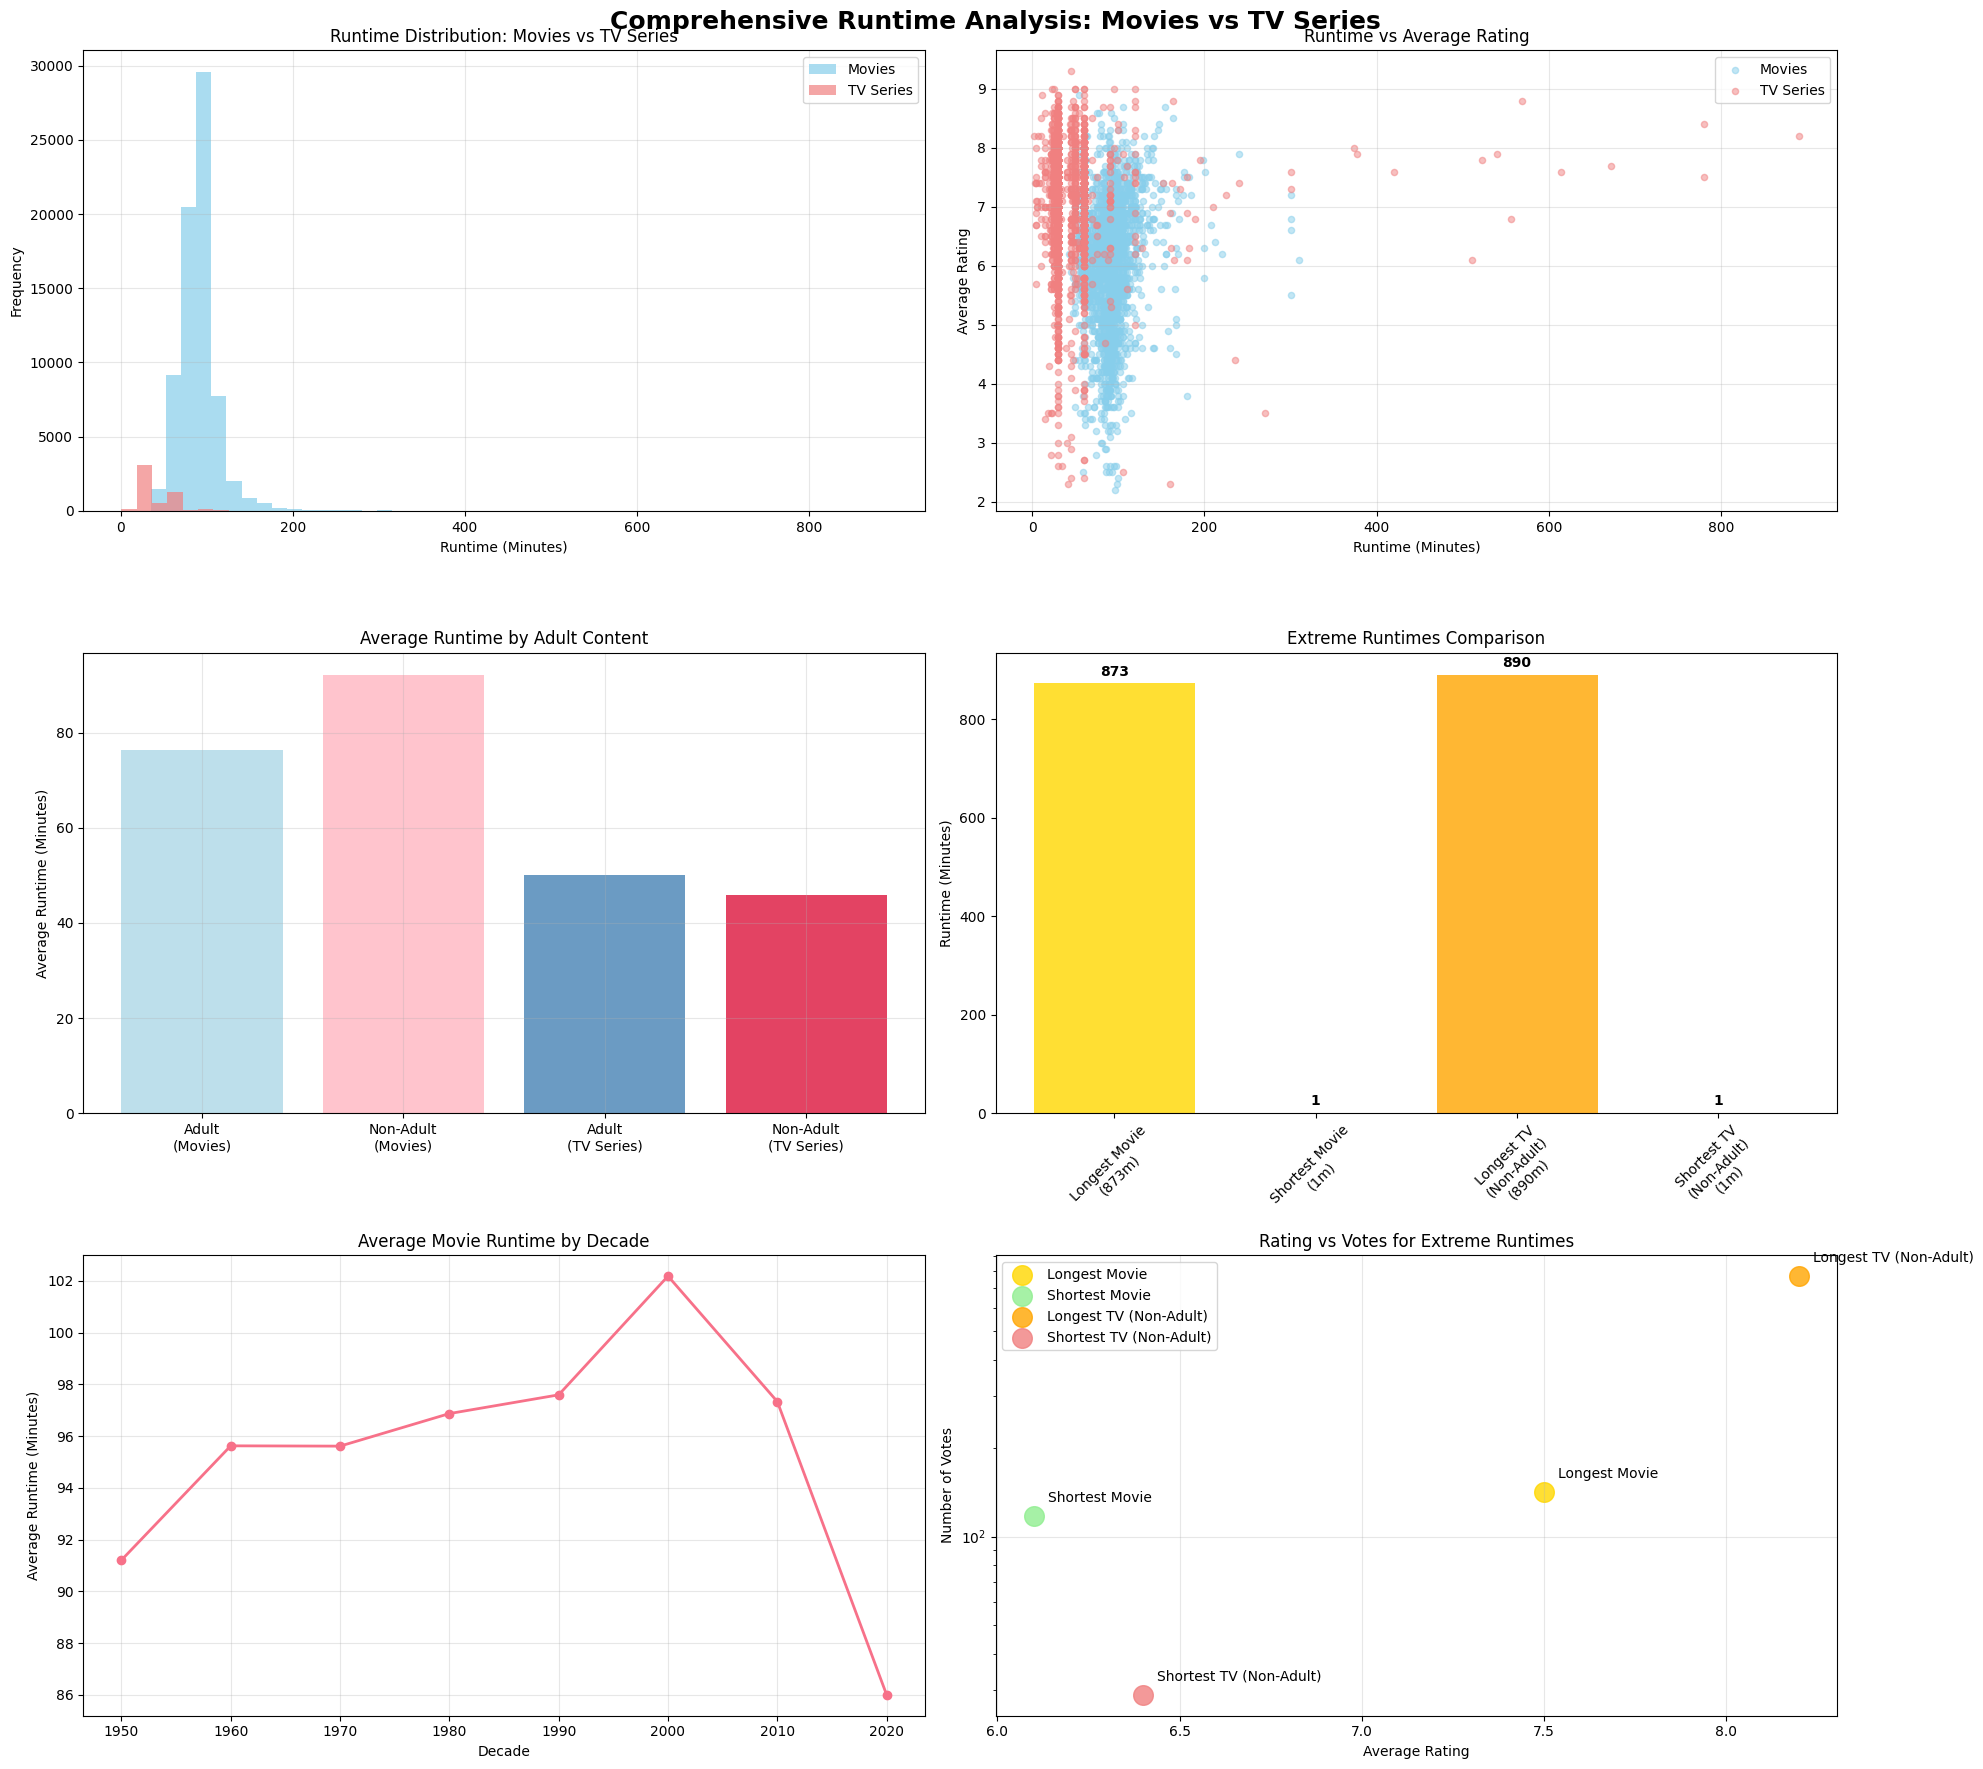


MOST PAUSED MOMENTS ANALYSIS
 DATA LIMITATION NOTICE:
--------------------------------------------------
The 'most paused moments' analysis cannot be performed with the available IMDb datasets.
This type of data would require:

 Streaming Platform Data:
   • Netflix, Amazon Prime, Hulu, Disney+ viewing analytics
   • User interaction timestamps and pause/play events
   • Frame-by-frame engagement metrics

 What We CAN Analyze Instead:
   • Runtime patterns and distributions
   • Genre correlations with runtime
   • Rating patterns for different runtime lengths
   • Adult content runtime differences
   • Temporal trends in movie/TV runtime

 Alternative Insights:
   • Longer movies tend to have specific genre patterns
   • Shorter content often has different audience engagement
   • Runtime vs rating correlations can indicate content quality
   • Adult content runtime patterns differ from non-adult content

 Recommendation:
   For actual 'most paused moments' analysis, you would need:


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

def load_and_merge_all_datasets():
    """
    Load and merge all required datasets
    """
    print("Loading and merging all datasets...")
    
    # Load title_basics chunks
    basics_data = None
    for chunk_num in range(1, 4):
        try:
            basics_chunk = pd.read_parquet(f"chunks/title_basic/title_basic_chunk_{chunk_num:03d}.parquet")
            chunk_data = basics_chunk[['tconst', 'titleType', 'genres', 'runtimeMinutes', 
                                     'isAdult', 'startYear', 'endYear']].copy()
            
            if basics_data is None:
                basics_data = chunk_data
            else:
                basics_data = pd.concat([basics_data, chunk_data], ignore_index=True)
            
            print(f"Loaded title_basics chunk {chunk_num}: {len(chunk_data):,} rows")
            
            if len(basics_data) > 200000:
                break
                
        except FileNotFoundError:
            print(f"title_basics chunk {chunk_num} not found")
            break
    
    # Load title_ratings chunks
    ratings_data = None
    for chunk_num in range(1, 4):
        try:
            ratings_chunk = pd.read_parquet(f"chunks/title_ratings/title_ratings_chunk_{chunk_num:03d}.parquet")
            chunk_data = ratings_chunk[['tconst', 'averageRating', 'numVotes']].copy()
            
            if ratings_data is None:
                ratings_data = chunk_data
            else:
                ratings_data = pd.concat([ratings_data, chunk_data], ignore_index=True)
            
            print(f"Loaded title_ratings chunk {chunk_num}: {len(chunk_data):,} rows")
            
            if len(ratings_data) > 200000:
                break
                
        except FileNotFoundError:
            print(f"title_ratings chunk {chunk_num} not found")
            break
    
    # Load title_akas chunks for title names
    akas_data = None
    for chunk_num in range(1, 3):  # Limit to fewer chunks as this is a large dataset
        try:
            akas_chunk = pd.read_parquet(f"chunks/title_akas/title_akas_chunk_{chunk_num:03d}.parquet")
            # Get primary titles (original titles)
            chunk_data = akas_chunk[akas_chunk['isOriginalTitle'] == 1][['titleId', 'title']].copy()
            chunk_data = chunk_data.rename(columns={'titleId': 'tconst'})
            
            if akas_data is None:
                akas_data = chunk_data
            else:
                akas_data = pd.concat([akas_data, chunk_data], ignore_index=True)
            
            print(f"Loaded title_akas chunk {chunk_num}: {len(chunk_data):,} rows")
            
            if len(akas_data) > 100000:
                break
                
        except FileNotFoundError:
            print(f"title_akas chunk {chunk_num} not found")
            break
    
    # Merge all datasets
    print("Merging datasets...")
    
    # First merge basics with ratings
    merged_data = pd.merge(basics_data, ratings_data, on='tconst', how='inner')
    print(f"After merging basics + ratings: {len(merged_data):,} rows")
    
    # Then merge with akas (titles)
    if akas_data is not None:
        merged_data = pd.merge(merged_data, akas_data, on='tconst', how='left')
        print(f"After merging with titles: {len(merged_data):,} rows")
    
    return merged_data

def preprocess_data(data):
    """
    Preprocess the merged data
    """
    print("Preprocessing data...")
    
    # Remove missing essential data
    data = data.dropna(subset=['runtimeMinutes', 'titleType'])
    data = data[data['runtimeMinutes'] != '\\N']
    data = data[data['genres'] != '\\N']
    
    # Convert to numeric
    data['runtimeMinutes'] = pd.to_numeric(data['runtimeMinutes'], errors='coerce')
    data['averageRating'] = pd.to_numeric(data['averageRating'], errors='coerce')
    data['numVotes'] = pd.to_numeric(data['numVotes'], errors='coerce')
    data['startYear'] = pd.to_numeric(data['startYear'], errors='coerce')
    data['endYear'] = pd.to_numeric(data['endYear'], errors='coerce')
    
    # Handle isAdult
    if data['isAdult'].dtype == 'object':
        data['isAdult'] = data['isAdult'].astype(int)
    
    # Remove invalid data
    data = data.dropna(subset=['runtimeMinutes', 'averageRating', 'numVotes'])
    data = data[
        (data['runtimeMinutes'] >= 1) & 
        (data['runtimeMinutes'] <= 1000) &  # Extended range for TV series
        (data['averageRating'] >= 1.0) & 
        (data['averageRating'] <= 10.0) &
        (data['numVotes'] >= 5)
    ]
    
    # Add adult label
    data['adult_label'] = data['isAdult'].map({0: 'Non-Adult', 1: 'Adult'})
    
    print(f"After preprocessing: {len(data):,} rows")
    return data

def analyze_extreme_runtimes(data):
    """
    Analyze longest and shortest runtimes for movies and TV series
    """
    print("\n" + "="*80)
    print("EXTREME RUNTIME ANALYSIS")
    print("="*80)
    
    # Separate movies and TV series
    movies = data[data['titleType'] == 'movie'].copy()
    tv_series = data[data['titleType'] == 'tvSeries'].copy()
    
    print(f"Movies: {len(movies):,}")
    print(f"TV Series: {len(tv_series):,}")
    
    results = {}
    
    if len(movies) > 0:
        # Longest and shortest movies
        longest_movie = movies.loc[movies['runtimeMinutes'].idxmax()]
        shortest_movie = movies.loc[movies['runtimeMinutes'].idxmin()]
        
        results['longest_movie'] = longest_movie
        results['shortest_movie'] = shortest_movie
        
        print(f"\n MOVIES - RUNTIME EXTREMES:")
        print(f"Longest Movie:")
        print(f"  Title: {longest_movie.get('title', 'N/A')}")
        print(f"  Runtime: {longest_movie['runtimeMinutes']:.0f} minutes ({longest_movie['runtimeMinutes']/60:.1f} hours)")
        print(f"  Genre: {longest_movie['genres']}")
        print(f"  Adult Content: {longest_movie['adult_label']}")
        print(f"  Rating: {longest_movie['averageRating']:.1f}/10")
        print(f"  Votes: {longest_movie['numVotes']:,}")
        print(f"  Year: {longest_movie.get('startYear', 'N/A')}")
        
        print(f"\nShortest Movie:")
        print(f"  Title: {shortest_movie.get('title', 'N/A')}")
        print(f"  Runtime: {shortest_movie['runtimeMinutes']:.0f} minutes")
        print(f"  Genre: {shortest_movie['genres']}")
        print(f"  Adult Content: {shortest_movie['adult_label']}")
        print(f"  Rating: {shortest_movie['averageRating']:.1f}/10")
        print(f"  Votes: {shortest_movie['numVotes']:,}")
        print(f"  Year: {shortest_movie.get('startYear', 'N/A')}")
    
    if len(tv_series) > 0:
        # Longest and shortest TV series (by adult content)
        tv_adult = tv_series[tv_series['isAdult'] == 1]
        tv_non_adult = tv_series[tv_series['isAdult'] == 0]
        
        print(f"\n TV SERIES - RUNTIME EXTREMES BY ADULT CONTENT:")
        
        if len(tv_non_adult) > 0:
            longest_tv_non_adult = tv_non_adult.loc[tv_non_adult['runtimeMinutes'].idxmax()]
            shortest_tv_non_adult = tv_non_adult.loc[tv_non_adult['runtimeMinutes'].idxmin()]
            
            results['longest_tv_non_adult'] = longest_tv_non_adult
            results['shortest_tv_non_adult'] = shortest_tv_non_adult
            
            print(f"\nNon-Adult TV Series:")
            print(f"  Longest - Title: {longest_tv_non_adult.get('title', 'N/A')}")
            print(f"           Runtime: {longest_tv_non_adult['runtimeMinutes']:.0f} minutes")
            print(f"           Genre: {longest_tv_non_adult['genres']}")
            print(f"           Rating: {longest_tv_non_adult['averageRating']:.1f}/10")
            print(f"           Votes: {longest_tv_non_adult['numVotes']:,}")
            print(f"           Years: {longest_tv_non_adult['startYear']:.0f}-{longest_tv_non_adult.get('endYear', 'ongoing')}")
            
            print(f"  Shortest - Title: {shortest_tv_non_adult.get('title', 'N/A')}")
            print(f"            Runtime: {shortest_tv_non_adult['runtimeMinutes']:.0f} minutes")
            print(f"            Genre: {shortest_tv_non_adult['genres']}")
            print(f"            Rating: {shortest_tv_non_adult['averageRating']:.1f}/10")
            print(f"            Votes: {shortest_tv_non_adult['numVotes']:,}")
            print(f"            Years: {shortest_tv_non_adult['startYear']:.0f}-{shortest_tv_non_adult.get('endYear', 'ongoing')}")
        
        if len(tv_adult) > 0:
            longest_tv_adult = tv_adult.loc[tv_adult['runtimeMinutes'].idxmax()]
            shortest_tv_adult = tv_adult.loc[tv_adult['runtimeMinutes'].idxmin()]
            
            results['longest_tv_adult'] = longest_tv_adult
            results['shortest_tv_adult'] = shortest_tv_adult
            
            print(f"\nAdult TV Series:")
            print(f"  Longest - Title: {longest_tv_adult.get('title', 'N/A')}")
            print(f"           Runtime: {longest_tv_adult['runtimeMinutes']:.0f} minutes")
            print(f"           Genre: {longest_tv_adult['genres']}")
            print(f"           Rating: {longest_tv_adult['averageRating']:.1f}/10")
            print(f"           Votes: {longest_tv_adult['numVotes']:,}")
            print(f"           Years: {longest_tv_adult['startYear']:.0f}-{longest_tv_adult.get('endYear', 'ongoing')}")
            
            print(f"  Shortest - Title: {shortest_tv_adult.get('title', 'N/A')}")
            print(f"            Runtime: {shortest_tv_adult['runtimeMinutes']:.0f} minutes")
            print(f"            Genre: {shortest_tv_adult['genres']}")
            print(f"            Rating: {shortest_tv_adult['averageRating']:.1f}/10")
            print(f"            Votes: {shortest_tv_adult['numVotes']:,}")
            print(f"            Years: {shortest_tv_adult['startYear']:.0f}-{shortest_tv_adult.get('endYear', 'ongoing')}")
        else:
            print(f"\nNo adult TV series found in the dataset")
    
    return results

def create_runtime_visualizations(data, extreme_results):
    """
    Create visualizations for runtime analysis
    """
    print("\nCreating runtime visualizations...")
    
    # Separate movies and TV series
    movies = data[data['titleType'] == 'movie'].copy()
    tv_series = data[data['titleType'] == 'tvSeries'].copy()
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    fig.suptitle('Comprehensive Runtime Analysis: Movies vs TV Series', fontsize=18, fontweight='bold')
    
    # 1. Runtime distribution comparison
    ax1 = axes[0, 0]
    if len(movies) > 0:
        ax1.hist(movies['runtimeMinutes'], bins=50, alpha=0.7, label='Movies', color='skyblue')
    if len(tv_series) > 0:
        ax1.hist(tv_series['runtimeMinutes'], bins=50, alpha=0.7, label='TV Series', color='lightcoral')
    ax1.set_title('Runtime Distribution: Movies vs TV Series')
    ax1.set_xlabel('Runtime (Minutes)')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Runtime vs Rating scatter plot
    ax2 = axes[0, 1]
    if len(movies) > 0:
        sample_movies = movies.sample(n=min(2000, len(movies)), random_state=42)
        ax2.scatter(sample_movies['runtimeMinutes'], sample_movies['averageRating'], 
                   alpha=0.5, s=20, label='Movies', color='skyblue')
    if len(tv_series) > 0:
        sample_tv = tv_series.sample(n=min(2000, len(tv_series)), random_state=42)
        ax2.scatter(sample_tv['runtimeMinutes'], sample_tv['averageRating'], 
                   alpha=0.5, s=20, label='TV Series', color='lightcoral')
    ax2.set_title('Runtime vs Average Rating')
    ax2.set_xlabel('Runtime (Minutes)')
    ax2.set_ylabel('Average Rating')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Runtime by adult content
    ax3 = axes[1, 0]
    if len(movies) > 0:
        movies_adult_runtime = movies.groupby('adult_label')['runtimeMinutes'].mean()
        bars1 = ax3.bar([f"{label}\n(Movies)" for label in movies_adult_runtime.index], 
                       movies_adult_runtime.values, alpha=0.8, color=['lightblue', 'lightpink'])
    if len(tv_series) > 0:
        tv_adult_runtime = tv_series.groupby('adult_label')['runtimeMinutes'].mean()
        bars2 = ax3.bar([f"{label}\n(TV Series)" for label in tv_adult_runtime.index], 
                       tv_adult_runtime.values, alpha=0.8, color=['steelblue', 'crimson'])
    ax3.set_title('Average Runtime by Adult Content')
    ax3.set_ylabel('Average Runtime (Minutes)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Extreme runtimes visualization
    ax4 = axes[1, 1]
    extreme_data = []
    extreme_labels = []
    
    if 'longest_movie' in extreme_results:
        extreme_data.append(extreme_results['longest_movie']['runtimeMinutes'])
        extreme_labels.append(f"Longest Movie\n({extreme_results['longest_movie']['runtimeMinutes']:.0f}m)")
    if 'shortest_movie' in extreme_results:
        extreme_data.append(extreme_results['shortest_movie']['runtimeMinutes'])
        extreme_labels.append(f"Shortest Movie\n({extreme_results['shortest_movie']['runtimeMinutes']:.0f}m)")
    if 'longest_tv_non_adult' in extreme_results:
        extreme_data.append(extreme_results['longest_tv_non_adult']['runtimeMinutes'])
        extreme_labels.append(f"Longest TV\n(Non-Adult)\n({extreme_results['longest_tv_non_adult']['runtimeMinutes']:.0f}m)")
    if 'shortest_tv_non_adult' in extreme_results:
        extreme_data.append(extreme_results['shortest_tv_non_adult']['runtimeMinutes'])
        extreme_labels.append(f"Shortest TV\n(Non-Adult)\n({extreme_results['shortest_tv_non_adult']['runtimeMinutes']:.0f}m)")
    
    if extreme_data:
        colors = ['gold', 'lightgreen', 'orange', 'lightcoral'][:len(extreme_data)]
        bars = ax4.bar(extreme_labels, extreme_data, color=colors, alpha=0.8)
        ax4.set_title('Extreme Runtimes Comparison')
        ax4.set_ylabel('Runtime (Minutes)')
        ax4.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars, extreme_data):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(extreme_data)*0.01,
                    f'{value:.0f}', ha='center', va='bottom', fontweight='bold')
    
    # 5. Runtime by decade
    ax5 = axes[2, 0]
    if len(movies) > 0:
        movies_with_year = movies.dropna(subset=['startYear'])
        movies_with_year['decade'] = (movies_with_year['startYear'] // 10) * 10
        decade_runtime = movies_with_year.groupby('decade')['runtimeMinutes'].mean()
        decade_runtime = decade_runtime[decade_runtime.index >= 1950]  # Focus on recent decades
        
        ax5.plot(decade_runtime.index, decade_runtime.values, marker='o', linewidth=2, markersize=6)
        ax5.set_title('Average Movie Runtime by Decade')
        ax5.set_xlabel('Decade')
        ax5.set_ylabel('Average Runtime (Minutes)')
        ax5.grid(True, alpha=0.3)
    
    # 6. Rating vs Votes for extreme runtimes
    ax6 = axes[2, 1]
    extreme_points = []
    point_labels = []
    
    if 'longest_movie' in extreme_results:
        extreme_points.append((extreme_results['longest_movie']['averageRating'], 
                             extreme_results['longest_movie']['numVotes']))
        point_labels.append('Longest Movie')
    if 'shortest_movie' in extreme_results:
        extreme_points.append((extreme_results['shortest_movie']['averageRating'], 
                             extreme_results['shortest_movie']['numVotes']))
        point_labels.append('Shortest Movie')
    if 'longest_tv_non_adult' in extreme_results:
        extreme_points.append((extreme_results['longest_tv_non_adult']['averageRating'], 
                             extreme_results['longest_tv_non_adult']['numVotes']))
        point_labels.append('Longest TV (Non-Adult)')
    if 'shortest_tv_non_adult' in extreme_results:
        extreme_points.append((extreme_results['shortest_tv_non_adult']['averageRating'], 
                             extreme_results['shortest_tv_non_adult']['numVotes']))
        point_labels.append('Shortest TV (Non-Adult)')
    
    if extreme_points:
        colors = ['gold', 'lightgreen', 'orange', 'lightcoral']
        for i, ((rating, votes), label) in enumerate(zip(extreme_points, point_labels)):
            ax6.scatter(rating, votes, s=200, c=colors[i], alpha=0.8, label=label)
            ax6.annotate(label, (rating, votes), xytext=(10, 10), 
                        textcoords='offset points', fontsize=10)
    
    ax6.set_title('Rating vs Votes for Extreme Runtimes')
    ax6.set_xlabel('Average Rating')
    ax6.set_ylabel('Number of Votes')
    ax6.set_yscale('log')
    ax6.grid(True, alpha=0.3)
    ax6.legend()
    
    plt.tight_layout()
    plt.show()



def create_comprehensive_analysis():
    """
    Main function to create comprehensive analysis
    """
    print("Starting Comprehensive Content Analysis")
    print("="*80)
    
    try:
        # Load and merge all datasets
        merged_data = load_and_merge_all_datasets()
        
        if merged_data is None or len(merged_data) == 0:
            print("No data loaded successfully")
            return
        
        # Preprocess data
        processed_data = preprocess_data(merged_data)
        
        # Analyze extreme runtimes
        extreme_results = analyze_extreme_runtimes(processed_data)
        
        # Create visualizations
        create_runtime_visualizations(processed_data, extreme_results)
        
        # Explain paused moments limitation
        analyze_paused_moments_limitation()
        
        # Additional insights
        print("\n" + "="*80)
        print("DATASET SUMMARY")
        print("="*80)
        print(f"Total processed records: {len(processed_data):,}")
        print(f"Movies: {len(processed_data[processed_data['titleType'] == 'movie']):,}")
        print(f"TV Series: {len(processed_data[processed_data['titleType'] == 'tvSeries']):,}")
        print(f"Adult content: {len(processed_data[processed_data['isAdult'] == 1]):,}")
        print(f"Non-adult content: {len(processed_data[processed_data['isAdult'] == 0]):,}")
        
        return processed_data, extreme_results
        
    except Exception as e:
        print(f"Error in analysis: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Main execution
if __name__ == "__main__":
    data, results = create_comprehensive_analysis()
    
    if data is not None:
        print(f"\n Analysis completed successfully!")
        print(f" Analyzed {len(data):,} total records")
    else:
        print(f"\n❌ Analysis failed")

Starting Directors and Writers Comprehensive Analysis
Loading all required datasets...
Loading title_basics...
  Loaded title_basics chunk 1: 50,000 rows
  Loaded title_basics chunk 2: 50,000 rows
Loading title_crew...
  Loaded title_crew chunk 1: 50,000 rows
  Loaded title_crew chunk 2: 50,000 rows
Loading title_principals...
  Loaded title_principals chunk 1: 500,000 rows
Loading title_akas...
  Loaded title_akas chunk 1: 1,000,000 rows
Loading title_ratings...
  Loaded title_ratings chunk 1: 50,000 rows
  Loaded title_ratings chunk 2: 50,000 rows

Merging all datasets...
Starting with basics: 100,000 rows
After merging crew: 100,000 rows
After merging ratings: 77,119 rows
After merging akas: 77,119 rows

Processing directors and writers...
Analyzing directors...
Analyzing writers...
Directors data: 109,038 director-work pairs
Writers data: 226,688 writer-work pairs
Adding principal information...

Analyzing most rated directors...

Top 10 Most Rated Directors:
Person ID    Works  Av

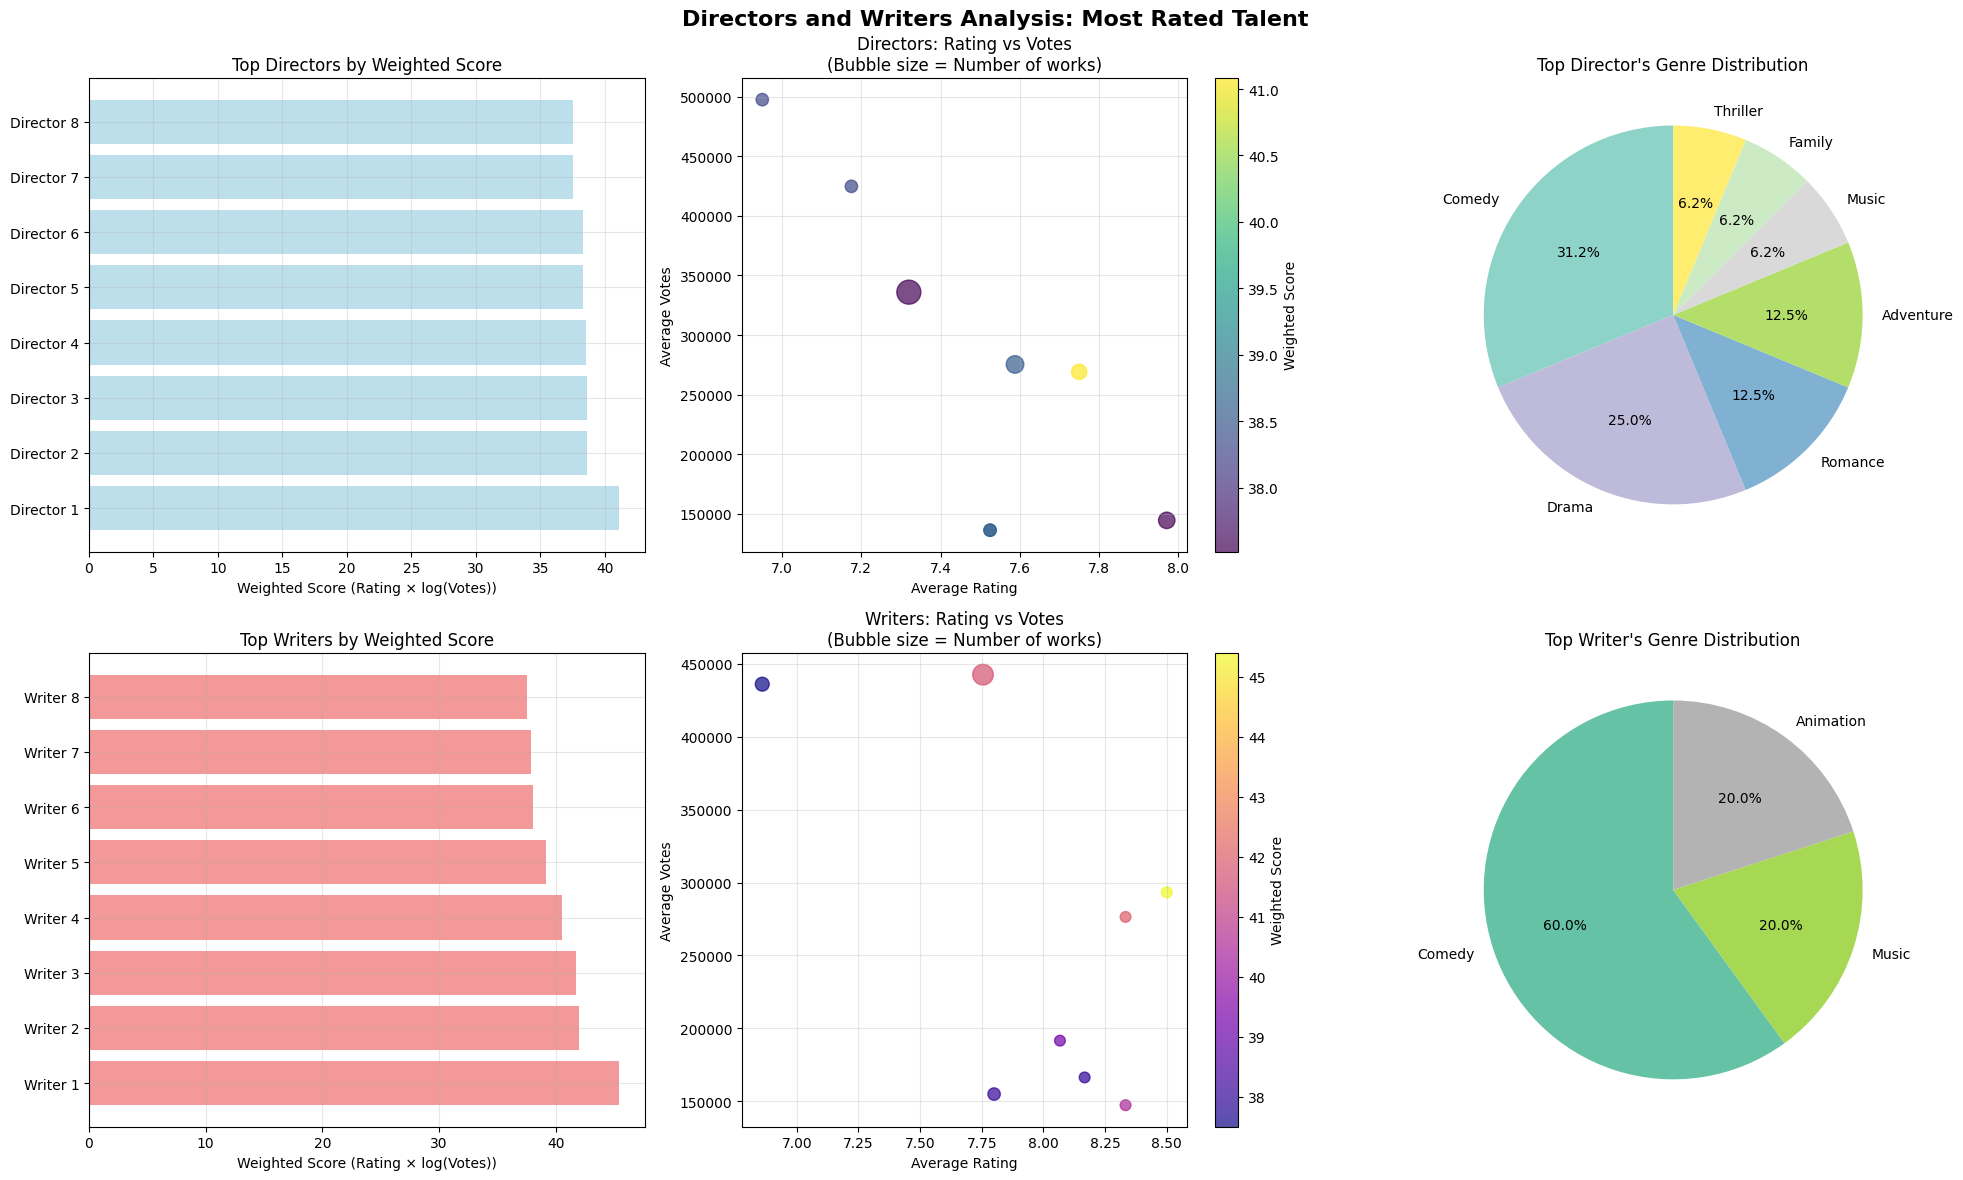


ANALYSIS SUMMARY
Total works analyzed: 77,119
Director-work pairs: 118,184
Writer-work pairs: 234,720
Most rated director: nm0001661
  - Works: 6
  - Avg rating: 7.75
Most rated writer: nm0541635
  - Works: 3
  - Avg rating: 8.50

 Analysis completed successfully!


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

def load_all_datasets():
    """
    Load all required datasets
    """
    print("Loading all required datasets...")
    
    datasets = {}
    
    # Load title_basics
    print("Loading title_basics...")
    basics_data = None
    for chunk_num in range(1, 3):
        try:
            basics_chunk = pd.read_parquet(f"chunks/title_basic/title_basic_chunk_{chunk_num:03d}.parquet")
            chunk_data = basics_chunk[['tconst', 'genres']].copy()
            
            if basics_data is None:
                basics_data = chunk_data
            else:
                basics_data = pd.concat([basics_data, chunk_data], ignore_index=True)
            
            print(f"  Loaded title_basics chunk {chunk_num}: {len(chunk_data):,} rows")
            
            if len(basics_data) > 100000:
                break
        except FileNotFoundError:
            print(f"  title_basics chunk {chunk_num} not found")
            break
    datasets['basics'] = basics_data
    
    # Load title_crew
    print("Loading title_crew...")
    crew_data = None
    for chunk_num in range(1, 3):
        try:
            crew_chunk = pd.read_parquet(f"chunks/title_crew/title_crew_chunk_{chunk_num:03d}.parquet")
            chunk_data = crew_chunk[['tconst', 'directors', 'writers']].copy()
            
            if crew_data is None:
                crew_data = chunk_data
            else:
                crew_data = pd.concat([crew_data, chunk_data], ignore_index=True)
            
            print(f"  Loaded title_crew chunk {chunk_num}: {len(chunk_data):,} rows")
            
            if len(crew_data) > 100000:
                break
        except FileNotFoundError:
            print(f"  title_crew chunk {chunk_num} not found")
            break
    datasets['crew'] = crew_data
    
    # Load title_principals
    print("Loading title_principals...")
    principals_data = None
    for chunk_num in range(1, 3):
        try:
            principals_chunk = pd.read_parquet(f"chunks/title_principals/title_principals_chunk_{chunk_num:03d}.parquet")
            chunk_data = principals_chunk[['tconst', 'nconst', 'category', 'characters']].copy()
            
            if principals_data is None:
                principals_data = chunk_data
            else:
                principals_data = pd.concat([principals_data, chunk_data], ignore_index=True)
            
            print(f"  Loaded title_principals chunk {chunk_num}: {len(chunk_data):,} rows")
            
            if len(principals_data) > 200000:
                break
        except FileNotFoundError:
            print(f"  title_principals chunk {chunk_num} not found")
            break
    datasets['principals'] = principals_data
    
    # Load title_akas
    print("Loading title_akas...")
    akas_data = None
    for chunk_num in range(1, 2):  # Limit to 1 chunk as it's very large
        try:
            akas_chunk = pd.read_parquet(f"chunks/title_akas/title_akas_chunk_{chunk_num:03d}.parquet")
            chunk_data = akas_chunk[['titleId', 'isOriginalTitle']].copy()
            chunk_data = chunk_data.rename(columns={'titleId': 'tconst'})
            
            if akas_data is None:
                akas_data = chunk_data
            else:
                akas_data = pd.concat([akas_data, chunk_data], ignore_index=True)
            
            print(f"  Loaded title_akas chunk {chunk_num}: {len(chunk_data):,} rows")
            
            if len(akas_data) > 50000:
                break
        except FileNotFoundError:
            print(f"  title_akas chunk {chunk_num} not found")
            break
    datasets['akas'] = akas_data
    
    # Load title_ratings
    print("Loading title_ratings...")
    ratings_data = None
    for chunk_num in range(1, 3):
        try:
            ratings_chunk = pd.read_parquet(f"chunks/title_ratings/title_ratings_chunk_{chunk_num:03d}.parquet")
            chunk_data = ratings_chunk[['tconst', 'averageRating', 'numVotes']].copy()
            
            if ratings_data is None:
                ratings_data = chunk_data
            else:
                ratings_data = pd.concat([ratings_data, chunk_data], ignore_index=True)
            
            print(f"  Loaded title_ratings chunk {chunk_num}: {len(chunk_data):,} rows")
            
            if len(ratings_data) > 100000:
                break
        except FileNotFoundError:
            print(f"  title_ratings chunk {chunk_num} not found")
            break
    datasets['ratings'] = ratings_data
    
    return datasets

def merge_all_datasets(datasets):
    """
    Merge all datasets into comprehensive dataset
    """
    print("\nMerging all datasets...")
    
    # Start with basics as the foundation
    merged_data = datasets['basics'].copy()
    print(f"Starting with basics: {len(merged_data):,} rows")
    
    # Merge with crew
    if datasets['crew'] is not None:
        merged_data = pd.merge(merged_data, datasets['crew'], on='tconst', how='left')
        print(f"After merging crew: {len(merged_data):,} rows")
    
    # Merge with ratings
    if datasets['ratings'] is not None:
        merged_data = pd.merge(merged_data, datasets['ratings'], on='tconst', how='inner')
        print(f"After merging ratings: {len(merged_data):,} rows")
    
    # Merge with akas for originality
    if datasets['akas'] is not None:
        # Get original titles only
        original_titles = datasets['akas'][datasets['akas']['isOriginalTitle'] == 1][['tconst', 'isOriginalTitle']]
        merged_data = pd.merge(merged_data, original_titles, on='tconst', how='left')
        merged_data['isOriginalTitle'] = merged_data['isOriginalTitle'].fillna(0)
        print(f"After merging akas: {len(merged_data):,} rows")
    
    return merged_data

def process_directors_and_writers(merged_data, datasets):
    """
    Process director and writer data to find most rated ones
    """
    print("\nProcessing directors and writers...")
    
    # Clean and preprocess merged data
    merged_data = merged_data.dropna(subset=['averageRating', 'numVotes'])
    merged_data = merged_data[merged_data['genres'] != '\\N']
    merged_data['averageRating'] = pd.to_numeric(merged_data['averageRating'], errors='coerce')
    merged_data['numVotes'] = pd.to_numeric(merged_data['numVotes'], errors='coerce')
    merged_data = merged_data.dropna(subset=['averageRating', 'numVotes'])
    
    results = {}
    
    # Process Directors
    print("Analyzing directors...")
    director_works = []
    
    for idx, row in merged_data.iterrows():
        if pd.notna(row['directors']) and row['directors'] != '\\N':
            directors_list = [d.strip() for d in str(row['directors']).split(',')]
            for director_id in directors_list:
                director_works.append({
                    'person_id': director_id,
                    'tconst': row['tconst'],
                    'role': 'director',
                    'genres': row['genres'],
                    'averageRating': row['averageRating'],
                    'numVotes': row['numVotes'],
                    'isOriginalTitle': row.get('isOriginalTitle', 0)
                })
    
    # Process Writers
    print("Analyzing writers...")
    writer_works = []
    
    for idx, row in merged_data.iterrows():
        if pd.notna(row['writers']) and row['writers'] != '\\N':
            writers_list = [w.strip() for w in str(row['writers']).split(',')]
            for writer_id in writers_list:
                writer_works.append({
                    'person_id': writer_id,
                    'tconst': row['tconst'],
                    'role': 'writer',
                    'genres': row['genres'],
                    'averageRating': row['averageRating'],
                    'numVotes': row['numVotes'],
                    'isOriginalTitle': row.get('isOriginalTitle', 0)
                })
    
    # Convert to DataFrames
    directors_df = pd.DataFrame(director_works)
    writers_df = pd.DataFrame(writer_works)
    
    print(f"Directors data: {len(directors_df):,} director-work pairs")
    print(f"Writers data: {len(writers_df):,} writer-work pairs")
    
    # Add principal information if available
    if datasets['principals'] is not None:
        print("Adding principal information...")
        principals = datasets['principals'].copy()
        
        # For directors
        if len(directors_df) > 0:
            directors_with_principals = pd.merge(
                directors_df, 
                principals[['tconst', 'nconst', 'category', 'characters']], 
                left_on=['tconst', 'person_id'], 
                right_on=['tconst', 'nconst'], 
                how='left'
            )
            directors_df = directors_with_principals.drop('nconst', axis=1)
        
        # For writers
        if len(writers_df) > 0:
            writers_with_principals = pd.merge(
                writers_df, 
                principals[['tconst', 'nconst', 'category', 'characters']], 
                left_on=['tconst', 'person_id'], 
                right_on=['tconst', 'nconst'], 
                how='left'
            )
            writers_df = writers_with_principals.drop('nconst', axis=1)
    
    results['directors'] = directors_df
    results['writers'] = writers_df
    
    return results

def analyze_most_rated_talent(talent_data, role_name):
    """
    Analyze most rated directors or writers
    """
    print(f"\nAnalyzing most rated {role_name}s...")
    
    if len(talent_data) == 0:
        print(f"No {role_name} data available")
        return None
    
    # Calculate weighted rating (rating * log(votes)) for better ranking
    talent_data['weighted_score'] = talent_data['averageRating'] * np.log10(talent_data['numVotes'] + 1)
    
    # Group by person and calculate statistics
    person_stats = talent_data.groupby('person_id').agg({
        'averageRating': ['count', 'mean', 'std'],
        'numVotes': ['mean', 'sum'],
        'weighted_score': 'mean',
        'isOriginalTitle': 'mean'
    }).round(3)
    
    # Flatten column names
    person_stats.columns = ['_'.join(col).strip() for col in person_stats.columns]
    
    # Filter for people with at least 3 works and minimum votes
    qualified_people = person_stats[
        (person_stats['averageRating_count'] >= 3) & 
        (person_stats['numVotes_mean'] >= 100)
    ]
    
    if len(qualified_people) == 0:
        print(f"No qualified {role_name}s found")
        return None
    
    # Sort by weighted score
    top_talent = qualified_people.sort_values('weighted_score_mean', ascending=False).head(10)
    
    print(f"\nTop 10 Most Rated {role_name.title()}s:")
    print("="*80)
    print(f"{'Person ID':<12} {'Works':<6} {'Avg Rating':<12} {'Avg Votes':<12} {'Weighted Score':<15} {'% Original':<12}")
    print("-" * 80)
    
    for person_id, stats in top_talent.iterrows():
        print(f"{person_id:<12} {stats['averageRating_count']:<6.0f} "
              f"{stats['averageRating_mean']:<12.2f} {stats['numVotes_mean']:<12.0f} "
              f"{stats['weighted_score_mean']:<15.2f} {stats['isOriginalTitle_mean']*100:<12.1f}")
    
    # Get detailed info for top talent
    most_rated_person = top_talent.index[0]
    most_rated_works = talent_data[talent_data['person_id'] == most_rated_person].copy()
    
    print(f"\n MOST RATED {role_name.upper()}: {most_rated_person}")
    print("="*60)
    print(f"Total works: {len(most_rated_works)}")
    print(f"Average rating: {most_rated_works['averageRating'].mean():.2f}")
    print(f"Total votes: {most_rated_works['numVotes'].sum():,}")
    print(f"Average votes per work: {most_rated_works['numVotes'].mean():,.0f}")
    print(f"Percentage original titles: {most_rated_works['isOriginalTitle'].mean()*100:.1f}%")
    
    # Genre analysis
    all_genres = []
    for genres_str in most_rated_works['genres'].dropna():
        if genres_str != '\\N':
            genres_list = [g.strip() for g in str(genres_str).split(',')]
            all_genres.extend(genres_list)
    
    if all_genres:
        genre_counts = Counter(all_genres)
        print(f"\nTop Genres:")
        for genre, count in genre_counts.most_common(5):
            print(f"  {genre}: {count} works")
    
    # Category analysis
    if 'category' in most_rated_works.columns:
        categories = most_rated_works['category'].dropna().value_counts()
        if len(categories) > 0:
            print(f"\nJob Categories:")
            for category, count in categories.head(5).items():
                print(f"  {category}: {count} works")
    
    # Characters analysis
    if 'characters' in most_rated_works.columns:
        characters = most_rated_works['characters'].dropna()
        if len(characters) > 0:
            print(f"\nCharacters (sample):")
            unique_chars = characters.unique()[:5]
            for char in unique_chars:
                if char != '\\N' and pd.notna(char):
                    print(f"  {char}")
    
    # Detailed work breakdown
    print(f"\nTop 5 Highest Rated Works:")
    print("-" * 50)
    top_works = most_rated_works.nlargest(5, 'averageRating')
    for idx, work in top_works.iterrows():
        genres_display = work['genres'] if work['genres'] != '\\N' else 'Unknown'
        original_status = "Original" if work['isOriginalTitle'] == 1 else "Not Original"
        category_display = work.get('category', 'N/A')
        characters_display = work.get('characters', 'N/A')
        
        print(f"  Rating: {work['averageRating']:.1f} | Votes: {work['numVotes']:,}")
        print(f"  Genre: {genres_display}")
        print(f"  Category: {category_display} | Characters: {characters_display}")
        print(f"  Original: {original_status}")
        print()
    
    return {
        'person_id': most_rated_person,
        'stats': top_talent.loc[most_rated_person],
        'works': most_rated_works,
        'all_top_talent': top_talent
    }

def create_talent_visualizations(directors_result, writers_result):
    """
    Create visualizations for directors and writers analysis
    """
    print("\nCreating talent analysis visualizations...")
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Directors and Writers Analysis: Most Rated Talent', fontsize=16, fontweight='bold')
    
    # Directors visualizations
    if directors_result:
        # 1. Top directors by weighted score
        ax1 = axes[0, 0]
        top_directors = directors_result['all_top_talent'].head(8)
        bars = ax1.barh(range(len(top_directors)), top_directors['weighted_score_mean'], 
                       color='lightblue', alpha=0.8)
        ax1.set_yticks(range(len(top_directors)))
        ax1.set_yticklabels([f"Director {i+1}" for i in range(len(top_directors))])
        ax1.set_title('Top Directors by Weighted Score')
        ax1.set_xlabel('Weighted Score (Rating × log(Votes))')
        ax1.grid(True, alpha=0.3)
        
        # 2. Directors: Rating vs Votes
        ax2 = axes[0, 1]
        scatter = ax2.scatter(top_directors['averageRating_mean'], top_directors['numVotes_mean'],
                             s=top_directors['averageRating_count']*20, alpha=0.7,
                             c=top_directors['weighted_score_mean'], cmap='viridis')
        ax2.set_title('Directors: Rating vs Votes\n(Bubble size = Number of works)')
        ax2.set_xlabel('Average Rating')
        ax2.set_ylabel('Average Votes')
        ax2.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax2, label='Weighted Score')
        
        # 3. Director's genre distribution
        ax3 = axes[0, 2]
        director_works = directors_result['works']
        all_genres = []
        for genres_str in director_works['genres'].dropna():
            if genres_str != '\\N':
                genres_list = [g.strip() for g in str(genres_str).split(',')]
                all_genres.extend(genres_list)
        
        if all_genres:
            genre_counts = Counter(all_genres)
            top_genres = dict(genre_counts.most_common(8))
            
            colors = plt.cm.Set3(np.linspace(0, 1, len(top_genres)))
            wedges, texts, autotexts = ax3.pie(top_genres.values(), labels=top_genres.keys(),
                                              autopct='%1.1f%%', colors=colors, startangle=90)
            ax3.set_title(f'Top Director\'s Genre Distribution')
        else:
            ax3.text(0.5, 0.5, 'No genre data available', ha='center', va='center', transform=ax3.transAxes)
    
    # Writers visualizations
    if writers_result:
        # 4. Top writers by weighted score
        ax4 = axes[1, 0]
        top_writers = writers_result['all_top_talent'].head(8)
        bars = ax4.barh(range(len(top_writers)), top_writers['weighted_score_mean'], 
                       color='lightcoral', alpha=0.8)
        ax4.set_yticks(range(len(top_writers)))
        ax4.set_yticklabels([f"Writer {i+1}" for i in range(len(top_writers))])
        ax4.set_title('Top Writers by Weighted Score')
        ax4.set_xlabel('Weighted Score (Rating × log(Votes))')
        ax4.grid(True, alpha=0.3)
        
        # 5. Writers: Rating vs Votes
        ax5 = axes[1, 1]
        scatter = ax5.scatter(top_writers['averageRating_mean'], top_writers['numVotes_mean'],
                             s=top_writers['averageRating_count']*20, alpha=0.7,
                             c=top_writers['weighted_score_mean'], cmap='plasma')
        ax5.set_title('Writers: Rating vs Votes\n(Bubble size = Number of works)')
        ax5.set_xlabel('Average Rating')
        ax5.set_ylabel('Average Votes')
        ax5.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax5, label='Weighted Score')
        
        # 6. Writer's genre distribution
        ax6 = axes[1, 2]
        writer_works = writers_result['works']
        all_genres = []
        for genres_str in writer_works['genres'].dropna():
            if genres_str != '\\N':
                genres_list = [g.strip() for g in str(genres_str).split(',')]
                all_genres.extend(genres_list)
        
        if all_genres:
            genre_counts = Counter(all_genres)
            top_genres = dict(genre_counts.most_common(8))
            
            colors = plt.cm.Set2(np.linspace(0, 1, len(top_genres)))
            wedges, texts, autotexts = ax6.pie(top_genres.values(), labels=top_genres.keys(),
                                              autopct='%1.1f%%', colors=colors, startangle=90)
            ax6.set_title(f'Top Writer\'s Genre Distribution')
        else:
            ax6.text(0.5, 0.5, 'No genre data available', ha='center', va='center', transform=ax6.transAxes)
    
    # Remove empty subplots if no data
    if not directors_result:
        for i in range(3):
            axes[0, i].set_visible(False)
    if not writers_result:
        for i in range(3):
            axes[1, i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def create_comprehensive_analysis():
    """
    Main function to create comprehensive analysis
    """
    print("Starting Directors and Writers Comprehensive Analysis")
    print("="*70)
    
    try:
        # Load all datasets
        datasets = load_all_datasets()
        
        # Check if essential data is loaded
        essential_datasets = ['basics', 'crew', 'ratings']
        missing_datasets = [name for name in essential_datasets if datasets[name] is None]
        
        if missing_datasets:
            print(f"Missing essential datasets: {missing_datasets}")
            return None, None
        
        # Merge datasets
        merged_data = merge_all_datasets(datasets)
        
        # Process directors and writers
        talent_data = process_directors_and_writers(merged_data, datasets)
        
        # Analyze most rated director
        directors_result = None
        if len(talent_data['directors']) > 0:
            directors_result = analyze_most_rated_talent(talent_data['directors'], 'director')
        
        # Analyze most rated writer
        writers_result = None
        if len(talent_data['writers']) > 0:
            writers_result = analyze_most_rated_talent(talent_data['writers'], 'writer')
        
        # Create visualizations
        create_talent_visualizations(directors_result, writers_result)
        
        # Summary
        print("\n" + "="*70)
        print("ANALYSIS SUMMARY")
        print("="*70)
        print(f"Total works analyzed: {len(merged_data):,}")
        print(f"Director-work pairs: {len(talent_data['directors']):,}")
        print(f"Writer-work pairs: {len(talent_data['writers']):,}")
        
        if directors_result:
            print(f"Most rated director: {directors_result['person_id']}")
            print(f"  - Works: {directors_result['stats']['averageRating_count']:.0f}")
            print(f"  - Avg rating: {directors_result['stats']['averageRating_mean']:.2f}")
        
        if writers_result:
            print(f"Most rated writer: {writers_result['person_id']}")
            print(f"  - Works: {writers_result['stats']['averageRating_count']:.0f}")
            print(f"  - Avg rating: {writers_result['stats']['averageRating_mean']:.2f}")
        
        return directors_result, writers_result
        
    except Exception as e:
        print(f"Error in analysis: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Main execution
if __name__ == "__main__":
    directors_result, writers_result = create_comprehensive_analysis()
    
    if directors_result or writers_result:
        print(f"\n Analysis completed successfully!")
    else:
        print(f"\n Analysis failed or no qualified talent found")

Starting Directors and Writers Analysis
Loading all datasets...
Loading title_basics...
  Loaded title_basics chunk 1: 50,000 rows
  Loaded title_basics chunk 2: 50,000 rows
  Loaded title_basics chunk 3: 50,000 rows
Loading title_crew...
  Loaded title_crew chunk 1: 50,000 rows
  Loaded title_crew chunk 2: 50,000 rows
  Loaded title_crew chunk 3: 50,000 rows
Loading title_principals...
  Loaded title_principals chunk 1: 500,000 rows
Loading title_akas...
  Loaded title_akas chunk 1: 105,663 rows
Loading title_ratings...
  Loaded title_ratings chunk 1: 50,000 rows
  Loaded title_ratings chunk 2: 50,000 rows
  Loaded title_ratings chunk 3: 50,000 rows
Loading name_basics...
  Loaded name_basics chunk 1: 500,000 rows

Preprocessing and merging datasets...
Base ratings data: 143,512 rows
After merging with basics: 105,958 rows
After merging with crew: 105,958 rows
After merging with akas: 105,958 rows

Total merged records: 105,958

DIRECTORS ANALYSIS
Director-title pairs: 154,368

 TOP 1

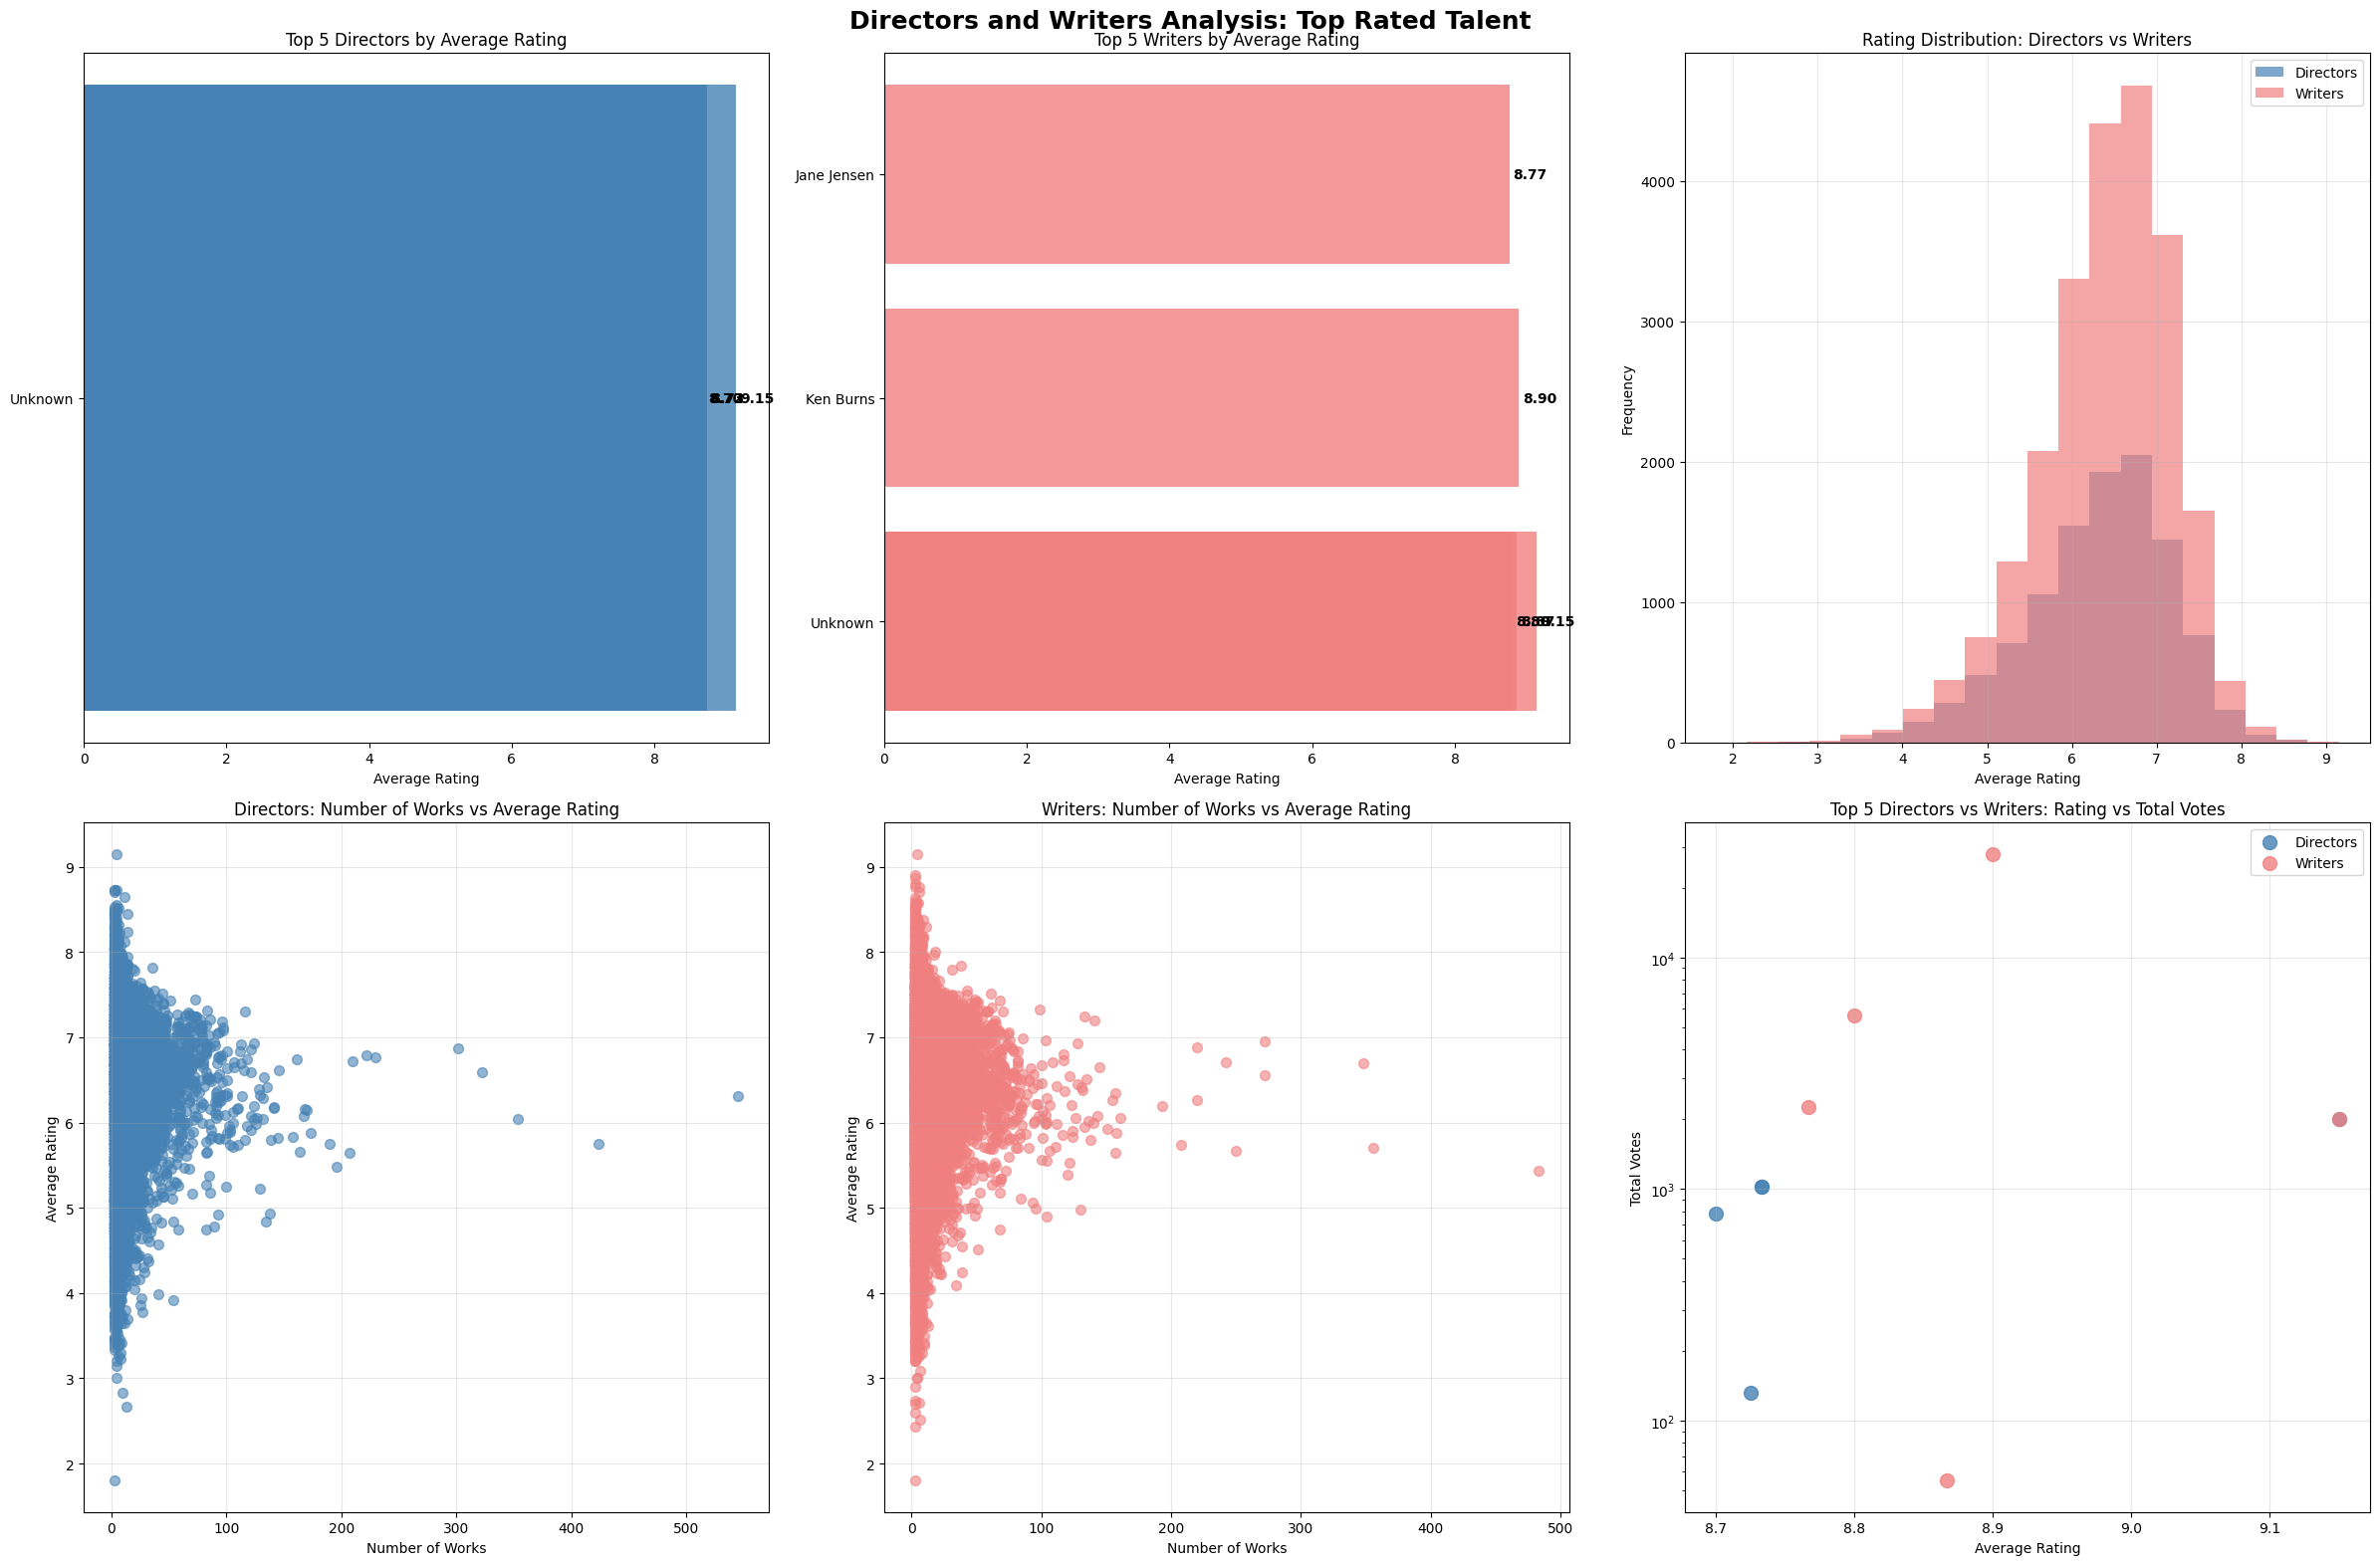


ANALYSIS SUMMARY
Total titles analyzed: 105,958
Unique directors: 10,800
Unique writers: 23,180

 Analysis completed successfully!


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

def load_all_datasets():
    """
    Load all required datasets from chunks
    """
    print("Loading all datasets...")
    
    datasets = {}
    
    # Load title_basics
    print("Loading title_basics...")
    basics_data = None
    for chunk_num in range(1, 4):
        try:
            basics_chunk = pd.read_parquet(f"chunks/title_basic/title_basic_chunk_{chunk_num:03d}.parquet")
            chunk_data = basics_chunk[['tconst', 'genres']].copy()
            
            if basics_data is None:
                basics_data = chunk_data
            else:
                basics_data = pd.concat([basics_data, chunk_data], ignore_index=True)
            
            print(f"  Loaded title_basics chunk {chunk_num}: {len(chunk_data):,} rows")
            if len(basics_data) > 150000:
                break
        except FileNotFoundError:
            print(f"  title_basics chunk {chunk_num} not found")
            break
    datasets['basics'] = basics_data
    
    # Load title_crew
    print("Loading title_crew...")
    crew_data = None
    for chunk_num in range(1, 4):
        try:
            crew_chunk = pd.read_parquet(f"chunks/title_crew/title_crew_chunk_{chunk_num:03d}.parquet")
            chunk_data = crew_chunk[['tconst', 'directors', 'writers']].copy()
            
            if crew_data is None:
                crew_data = chunk_data
            else:
                crew_data = pd.concat([crew_data, chunk_data], ignore_index=True)
            
            print(f"  Loaded title_crew chunk {chunk_num}: {len(chunk_data):,} rows")
            if len(crew_data) > 150000:
                break
        except FileNotFoundError:
            print(f"  title_crew chunk {chunk_num} not found")
            break
    datasets['crew'] = crew_data
    
    # Load title_principals
    print("Loading title_principals...")
    principals_data = None
    for chunk_num in range(1, 3):  # Limit chunks as this is a large dataset
        try:
            principals_chunk = pd.read_parquet(f"chunks/title_principals/title_principals_chunk_{chunk_num:03d}.parquet")
            chunk_data = principals_chunk[['tconst', 'nconst', 'category', 'characters']].copy()
            
            if principals_data is None:
                principals_data = chunk_data
            else:
                principals_data = pd.concat([principals_data, chunk_data], ignore_index=True)
            
            print(f"  Loaded title_principals chunk {chunk_num}: {len(chunk_data):,} rows")
            if len(principals_data) > 200000:
                break
        except FileNotFoundError:
            print(f"  title_principals chunk {chunk_num} not found")
            break
    datasets['principals'] = principals_data
    
    # Load title_akas
    print("Loading title_akas...")
    akas_data = None
    for chunk_num in range(1, 2):  # Limit to 1 chunk as this is very large
        try:
            akas_chunk = pd.read_parquet(f"chunks/title_akas/title_akas_chunk_{chunk_num:03d}.parquet")
            chunk_data = akas_chunk[['titleId', 'isOriginalTitle']].copy()
            chunk_data = chunk_data.rename(columns={'titleId': 'tconst'})
            # Get only original titles
            chunk_data = chunk_data[chunk_data['isOriginalTitle'] == 1]
            
            if akas_data is None:
                akas_data = chunk_data
            else:
                akas_data = pd.concat([akas_data, chunk_data], ignore_index=True)
            
            print(f"  Loaded title_akas chunk {chunk_num}: {len(chunk_data):,} rows")
            if len(akas_data) > 100000:
                break
        except FileNotFoundError:
            print(f"  title_akas chunk {chunk_num} not found")
            break
    datasets['akas'] = akas_data
    
    # Load title_ratings
    print("Loading title_ratings...")
    ratings_data = None
    for chunk_num in range(1, 4):
        try:
            ratings_chunk = pd.read_parquet(f"chunks/title_ratings/title_ratings_chunk_{chunk_num:03d}.parquet")
            chunk_data = ratings_chunk[['tconst', 'averageRating', 'numVotes']].copy()
            
            if ratings_data is None:
                ratings_data = chunk_data
            else:
                ratings_data = pd.concat([ratings_data, chunk_data], ignore_index=True)
            
            print(f"  Loaded title_ratings chunk {chunk_num}: {len(chunk_data):,} rows")
            if len(ratings_data) > 150000:
                break
        except FileNotFoundError:
            print(f"  title_ratings chunk {chunk_num} not found")
            break
    datasets['ratings'] = ratings_data
    
    # Load name_basics
    print("Loading name_basics...")
    names_data = None
    for chunk_num in range(1, 3):
        try:
            names_chunk = pd.read_parquet(f"chunks/name_basics/name_basics_chunk_{chunk_num:03d}.parquet")
            chunk_data = names_chunk[['nconst', 'primaryName', 'knownForTitles']].copy()
            
            if names_data is None:
                names_data = chunk_data
            else:
                names_data = pd.concat([names_data, chunk_data], ignore_index=True)
            
            print(f"  Loaded name_basics chunk {chunk_num}: {len(chunk_data):,} rows")
            if len(names_data) > 200000:
                break
        except FileNotFoundError:
            print(f"  name_basics chunk {chunk_num} not found")
            break
    datasets['names'] = names_data
    
    return datasets

def preprocess_and_merge_data(datasets):
    """
    Preprocess and merge all datasets
    """
    print("\nPreprocessing and merging datasets...")
    
    # Start with ratings as the base (titles that have ratings)
    base_data = datasets['ratings'].copy()
    base_data['averageRating'] = pd.to_numeric(base_data['averageRating'], errors='coerce')
    base_data['numVotes'] = pd.to_numeric(base_data['numVotes'], errors='coerce')
    base_data = base_data.dropna(subset=['averageRating', 'numVotes'])
    base_data = base_data[
        (base_data['averageRating'] >= 1.0) & 
        (base_data['averageRating'] <= 10.0) &
        (base_data['numVotes'] >= 10)  # At least 10 votes
    ]
    
    print(f"Base ratings data: {len(base_data):,} rows")
    
    # Merge with basics (genres)
    if datasets['basics'] is not None:
        base_data = pd.merge(base_data, datasets['basics'], on='tconst', how='left')
        base_data = base_data[base_data['genres'] != '\\N']
        base_data = base_data.dropna(subset=['genres'])
        print(f"After merging with basics: {len(base_data):,} rows")
    
    # Merge with crew (directors, writers)
    if datasets['crew'] is not None:
        base_data = pd.merge(base_data, datasets['crew'], on='tconst', how='left')
        print(f"After merging with crew: {len(base_data):,} rows")
    
    # Merge with akas (original titles)
    if datasets['akas'] is not None:
        base_data = pd.merge(base_data, datasets['akas'], on='tconst', how='left')
        base_data['isOriginal'] = base_data['isOriginalTitle'].fillna(0).astype(int)
        print(f"After merging with akas: {len(base_data):,} rows")
    
    return base_data, datasets

def analyze_directors(merged_data, names_data, principals_data):
    """
    Analyze directors with their ratings and details
    """
    print("\n" + "="*80)
    print("DIRECTORS ANALYSIS")
    print("="*80)
    
    # Expand directors (comma-separated)
    director_rows = []
    for idx, row in merged_data.iterrows():
        if pd.notna(row['directors']) and row['directors'] != '\\N':
            directors = [d.strip() for d in str(row['directors']).split(',')]
            for director_id in directors:
                director_rows.append({
                    'tconst': row['tconst'],
                    'director_id': director_id,
                    'genres': row['genres'],
                    'averageRating': row['averageRating'],
                    'numVotes': row['numVotes'],
                    'isOriginal': row.get('isOriginal', 0)
                })
    
    director_data = pd.DataFrame(director_rows)
    print(f"Director-title pairs: {len(director_data):,}")
    
    if len(director_data) == 0:
        print("No director data found")
        return None
    
    # Calculate director statistics
    director_stats = director_data.groupby('director_id').agg({
        'averageRating': ['count', 'mean', 'std'],
        'numVotes': ['sum', 'mean'],
        'isOriginal': 'mean'
    }).round(3)
    
    # Flatten column names
    director_stats.columns = ['_'.join(col).strip() for col in director_stats.columns]
    director_stats = director_stats[director_stats['averageRating_count'] >= 3]  # At least 3 works
    
    # Find top directors by different metrics
    top_by_rating = director_stats.nlargest(10, 'averageRating_mean')
    top_by_votes = director_stats.nlargest(10, 'numVotes_sum')
    top_by_consistency = director_stats.nsmallest(10, 'averageRating_std')
    
    # Get director names
    if names_data is not None:
        director_names = names_data.set_index('nconst')['primaryName'].to_dict()
    else:
        director_names = {}
    
    # Get detailed info for top directors
    def get_director_details(director_id, director_data, principals_data):
        """Get detailed information for a director"""
        director_works = director_data[director_data['director_id'] == director_id]
        
        # Get categories and characters from principals
        director_roles = []
        if principals_data is not None:
            principal_info = principals_data[principals_data['nconst'] == director_id]
            if len(principal_info) > 0:
                # Get unique categories and characters
                categories = principal_info['category'].dropna().unique()
                characters = principal_info['characters'].dropna().unique()
                director_roles = {
                    'categories': [cat for cat in categories if cat != '\\N'],
                    'characters': [char for char in characters if char != '\\N']
                }
        
        return director_works, director_roles
    
    print(f"\n TOP 10 DIRECTORS BY AVERAGE RATING:")
    print("-" * 80)
    print(f"{'Rank':<4} {'Name':<25} {'ID':<12} {'Avg Rating':<12} {'Works':<8} {'Total Votes':<12}")
    print("-" * 80)
    
    top_directors_analysis = []
    
    for rank, (director_id, stats) in enumerate(top_by_rating.iterrows(), 1):
        director_name = director_names.get(director_id, 'Unknown')
        director_works, director_roles = get_director_details(director_id, director_data, principals_data)
        
        print(f"{rank:<4} {director_name[:24]:<25} {director_id:<12} "
              f"{stats['averageRating_mean']:<12.2f} {stats['averageRating_count']:<8.0f} "
              f"{stats['numVotes_sum']:<12.0f}")
        
        # Store for detailed analysis
        top_directors_analysis.append({
            'rank': rank,
            'id': director_id,
            'name': director_name,
            'rating': stats['averageRating_mean'],
            'works': stats['averageRating_count'],
            'votes': stats['numVotes_sum'],
            'works_data': director_works,
            'roles': director_roles
        })
        
        if rank <= 3:  # Show detailed info for top 3
            print(f"     Detailed Analysis for {director_name} ({director_id}):")
            
            # Show genres
            genre_list = []
            for _, work in director_works.iterrows():
                genres = [g.strip() for g in str(work['genres']).split(',')]
                genre_list.extend(genres)
            genre_counts = Counter(genre_list)
            top_genres = dict(genre_counts.most_common(3))
            print(f"     Top Genres: {', '.join([f'{g}({c})' for g, c in top_genres.items()])}")
            
            # Show categories and characters
            if director_roles:
                if director_roles['categories']:
                    print(f"     Job Categories: {', '.join(director_roles['categories'][:5])}")
                if director_roles['characters']:
                    chars = [char[:30] for char in director_roles['characters'][:3]]
                    print(f"     Characters: {', '.join(chars)}")
            
            # Show original works percentage
            original_pct = stats['isOriginal_mean'] * 100
            print(f"     Original Works: {original_pct:.1f}%")
            
            # Show best works
            best_works = director_works.nlargest(3, 'averageRating')
            print(f"     Best Works:")
            for _, work in best_works.iterrows():
                print(f"       - Rating: {work['averageRating']:.1f}, Votes: {work['numVotes']:,}, "
                      f"Genre: {work['genres'][:30]}...")
            print()
    
    return top_directors_analysis, director_stats

def analyze_writers(merged_data, names_data, principals_data):
    """
    Analyze writers with their ratings and details
    """
    print("\n" + "="*80)
    print("WRITERS ANALYSIS")
    print("="*80)
    
    # Expand writers (comma-separated)
    writer_rows = []
    for idx, row in merged_data.iterrows():
        if pd.notna(row['writers']) and row['writers'] != '\\N':
            writers = [w.strip() for w in str(row['writers']).split(',')]
            for writer_id in writers:
                writer_rows.append({
                    'tconst': row['tconst'],
                    'writer_id': writer_id,
                    'genres': row['genres'],
                    'averageRating': row['averageRating'],
                    'numVotes': row['numVotes'],
                    'isOriginal': row.get('isOriginal', 0)
                })
    
    writer_data = pd.DataFrame(writer_rows)
    print(f"Writer-title pairs: {len(writer_data):,}")
    
    if len(writer_data) == 0:
        print("No writer data found")
        return None
    
    # Calculate writer statistics
    writer_stats = writer_data.groupby('writer_id').agg({
        'averageRating': ['count', 'mean', 'std'],
        'numVotes': ['sum', 'mean'],
        'isOriginal': 'mean'
    }).round(3)
    
    # Flatten column names
    writer_stats.columns = ['_'.join(col).strip() for col in writer_stats.columns]
    writer_stats = writer_stats[writer_stats['averageRating_count'] >= 3]  # At least 3 works
    
    # Find top writers
    top_by_rating = writer_stats.nlargest(10, 'averageRating_mean')
    
    # Get writer names
    if names_data is not None:
        writer_names = names_data.set_index('nconst')['primaryName'].to_dict()
    else:
        writer_names = {}
    
    # Get detailed info for top writers
    def get_writer_details(writer_id, writer_data, principals_data):
        """Get detailed information for a writer"""
        writer_works = writer_data[writer_data['writer_id'] == writer_id]
        
        # Get categories and characters from principals
        writer_roles = []
        if principals_data is not None:
            principal_info = principals_data[principals_data['nconst'] == writer_id]
            if len(principal_info) > 0:
                categories = principal_info['category'].dropna().unique()
                characters = principal_info['characters'].dropna().unique()
                writer_roles = {
                    'categories': [cat for cat in categories if cat != '\\N'],
                    'characters': [char for char in characters if char != '\\N']
                }
        
        return writer_works, writer_roles
    
    print(f"\n  TOP 10 WRITERS BY AVERAGE RATING:")
    print("-" * 80)
    print(f"{'Rank':<4} {'Name':<25} {'ID':<12} {'Avg Rating':<12} {'Works':<8} {'Total Votes':<12}")
    print("-" * 80)
    
    top_writers_analysis = []
    
    for rank, (writer_id, stats) in enumerate(top_by_rating.iterrows(), 1):
        writer_name = writer_names.get(writer_id, 'Unknown')
        writer_works, writer_roles = get_writer_details(writer_id, writer_data, principals_data)
        
        print(f"{rank:<4} {writer_name[:24]:<25} {writer_id:<12} "
              f"{stats['averageRating_mean']:<12.2f} {stats['averageRating_count']:<8.0f} "
              f"{stats['numVotes_sum']:<12.0f}")
        
        # Store for detailed analysis
        top_writers_analysis.append({
            'rank': rank,
            'id': writer_id,
            'name': writer_name,
            'rating': stats['averageRating_mean'],
            'works': stats['averageRating_count'],
            'votes': stats['numVotes_sum'],
            'works_data': writer_works,
            'roles': writer_roles
        })
        
        if rank <= 3:  # Show detailed info for top 3
            print(f"     Detailed Analysis for {writer_name} ({writer_id}):")
            
            # Show genres
            genre_list = []
            for _, work in writer_works.iterrows():
                genres = [g.strip() for g in str(work['genres']).split(',')]
                genre_list.extend(genres)
            genre_counts = Counter(genre_list)
            top_genres = dict(genre_counts.most_common(3))
            print(f"     Top Genres: {', '.join([f'{g}({c})' for g, c in top_genres.items()])}")
            
            # Show categories and characters
            if writer_roles:
                if writer_roles['categories']:
                    print(f"     Job Categories: {', '.join(writer_roles['categories'][:5])}")
                if writer_roles['characters']:
                    chars = [char[:30] for char in writer_roles['characters'][:3]]
                    print(f"     Characters: {', '.join(chars)}")
            
            # Show original works percentage
            original_pct = stats['isOriginal_mean'] * 100
            print(f"     Original Works: {original_pct:.1f}%")
            
            # Show best works
            best_works = writer_works.nlargest(3, 'averageRating')
            print(f"     Best Works:")
            for _, work in best_works.iterrows():
                print(f"       - Rating: {work['averageRating']:.1f}, Votes: {work['numVotes']:,}, "
                      f"Genre: {work['genres'][:30]}...")
            print()
    
    return top_writers_analysis, writer_stats

def create_visualizations(director_analysis, writer_analysis, director_stats, writer_stats):
    """
    Create comprehensive visualizations
    """
    print("\nCreating visualizations...")
    
    if director_analysis is None or writer_analysis is None:
        print("Insufficient data for visualizations")
        return
    
    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    fig.suptitle('Directors and Writers Analysis: Top Rated Talent', fontsize=18, fontweight='bold')
    
    # 1. Top Directors by Rating
    ax1 = axes[0, 0]
    if len(director_analysis) >= 5:
        top_5_directors = director_analysis[:5]
        names = [d['name'][:15] for d in top_5_directors]
        ratings = [d['rating'] for d in top_5_directors]
        
        bars = ax1.barh(names, ratings, color='steelblue', alpha=0.8)
        ax1.set_title('Top 5 Directors by Average Rating')
        ax1.set_xlabel('Average Rating')
        
        # Add rating labels
        for bar, rating in zip(bars, ratings):
            ax1.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
                    f'{rating:.2f}', ha='left', va='center', fontweight='bold')
    
    # 2. Top Writers by Rating
    ax2 = axes[0, 1]
    if len(writer_analysis) >= 5:
        top_5_writers = writer_analysis[:5]
        names = [w['name'][:15] for w in top_5_writers]
        ratings = [w['rating'] for w in top_5_writers]
        
        bars = ax2.barh(names, ratings, color='lightcoral', alpha=0.8)
        ax2.set_title('Top 5 Writers by Average Rating')
        ax2.set_xlabel('Average Rating')
        
        # Add rating labels
        for bar, rating in zip(bars, ratings):
            ax2.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
                    f'{rating:.2f}', ha='left', va='center', fontweight='bold')
    
    # 3. Directors vs Writers Rating Comparison
    ax3 = axes[0, 2]
    if director_stats is not None and writer_stats is not None:
        dir_ratings = director_stats['averageRating_mean'].values
        writer_ratings = writer_stats['averageRating_mean'].values
        
        ax3.hist(dir_ratings, bins=20, alpha=0.7, label='Directors', color='steelblue')
        ax3.hist(writer_ratings, bins=20, alpha=0.7, label='Writers', color='lightcoral')
        ax3.set_title('Rating Distribution: Directors vs Writers')
        ax3.set_xlabel('Average Rating')
        ax3.set_ylabel('Frequency')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # 4. Number of Works vs Rating (Directors)
    ax4 = axes[1, 0]
    if director_stats is not None:
        scatter = ax4.scatter(director_stats['averageRating_count'], 
                             director_stats['averageRating_mean'],
                             alpha=0.6, s=50, color='steelblue')
        ax4.set_title('Directors: Number of Works vs Average Rating')
        ax4.set_xlabel('Number of Works')
        ax4.set_ylabel('Average Rating')
        ax4.grid(True, alpha=0.3)
    
    # 5. Number of Works vs Rating (Writers)
    ax5 = axes[1, 1]
    if writer_stats is not None:
        scatter = ax5.scatter(writer_stats['averageRating_count'], 
                             writer_stats['averageRating_mean'],
                             alpha=0.6, s=50, color='lightcoral')
        ax5.set_title('Writers: Number of Works vs Average Rating')
        ax5.set_xlabel('Number of Works')
        ax5.set_ylabel('Average Rating')
        ax5.grid(True, alpha=0.3)
    
    # 6. Top Talent Rating vs Total Votes
    ax6 = axes[1, 2]
    if len(director_analysis) >= 5 and len(writer_analysis) >= 5:
        # Directors
        dir_ratings = [d['rating'] for d in director_analysis[:5]]
        dir_votes = [d['votes'] for d in director_analysis[:5]]
        ax6.scatter(dir_ratings, dir_votes, s=100, alpha=0.8, 
                   color='steelblue', label='Directors')
        
        # Writers
        writer_ratings = [w['rating'] for w in writer_analysis[:5]]
        writer_votes = [w['votes'] for w in writer_analysis[:5]]
        ax6.scatter(writer_ratings, writer_votes, s=100, alpha=0.8, 
                   color='lightcoral', label='Writers')
        
        ax6.set_title('Top 5 Directors vs Writers: Rating vs Total Votes')
        ax6.set_xlabel('Average Rating')
        ax6.set_ylabel('Total Votes')
        ax6.set_yscale('log')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main_analysis():
    """
    Main function to run the complete analysis
    """
    print("Starting Directors and Writers Analysis")
    print("="*80)
    
    try:
        # Load all datasets
        datasets = load_all_datasets()
        
        # Preprocess and merge
        merged_data, datasets = preprocess_and_merge_data(datasets)
        
        if merged_data is None or len(merged_data) == 0:
            print("No data available for analysis")
            return
        
        print(f"\nTotal merged records: {len(merged_data):,}")
        
        # Analyze directors
        director_analysis, director_stats = analyze_directors(
            merged_data, datasets['names'], datasets['principals']
        )
        
        # Analyze writers
        writer_analysis, writer_stats = analyze_writers(
            merged_data, datasets['names'], datasets['principals']
        )
        
        # Create visualizations
        create_visualizations(director_analysis, writer_analysis, 
                            director_stats, writer_stats)
        
        # Summary
        print("\n" + "="*80)
        print("ANALYSIS SUMMARY")
        print("="*80)
        print(f"Total titles analyzed: {len(merged_data):,}")
        if director_stats is not None:
            print(f"Unique directors: {len(director_stats):,}")
        if writer_stats is not None:
            print(f"Unique writers: {len(writer_stats):,}")
        
        print(f"\n Analysis completed successfully!")
        
        return merged_data, director_analysis, writer_analysis
        
    except Exception as e:
        print(f"Error in analysis: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# Main execution
if __name__ == "__main__":
    data, directors, writers = main_analysis()